# Build regression model from formation signals

Create a simple linear regression model that maps formation signals to end-of-life features.

Created: 4/18/2021

Author: Andrew Weng

In [109]:
import os, sys

if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../')
sys.path.append('code')

import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm, colors
from matplotlib import pyplot as plt

from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from itertools import product

import ipdb

from src.formation import FormationCell
from src.utils import get_label_registry

# Make sure user is in the right directory
assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
def config_plots():
    # Configure plot settings
    plt.rc('font', **{'family'     : 'sans-serif',
                      'sans-serif' : ['Arial'],
                      'size': 18
                      })
    plt.rc('figure', **{'autolayout' : True,
                        'figsize'    : (7, 5),
                        'facecolor'  : 'white',
                        'dpi'        : 150
                        })
    plt.rc('xtick', labelsize='medium')
    plt.rc('ytick', labelsize='medium')
    plt.rc('axes',  labelsize='medium', grid=False)
    plt.rc('axes',  titlesize='medium')
    plt.rc('legend', fontsize='medium')

config_plots()
cmap = cm.get_cmap('Set1', 10)

In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = 'k'
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = 'b'
COLOR_FAST_HT = 'r'
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = 'b'
COLOR_NEG = 'r'
COLOR_FULL_CELL = 'k'

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

## Point to the dataset

In [5]:
DATA_INPUT_PATH = 'output/2021-03-fast-formation-esoh-fits/correlation_data.csv';

assert os.path.isfile(DATA_INPUT_PATH), "Input data file is missing or is in the wrong directory."

## Load the correlation data

In [6]:
df = pd.read_csv(DATA_INPUT_PATH)

df = df[df['cellid'] != 9] # tab weld issue cell; exclude from entire study

# A single cell had a blatantly unphysical voltage fitting result; exclude this
df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan 
df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan 

# Cycle indices corresponding to RPTs, plus one at the beginning for "formation"
cyc_idx_rpt_arr = [1, 3, 56, 159, 262, 365]

# Keep only high temperature data / ignore room temperature data
df = df[df['is_room_temp_aging'] == 0]

# Here are the available features
for feature in sorted(df.columns):
    print(feature)

Unnamed: 0
cellid
channel_number
cycles_to_50_pct
cycles_to_60_pct
cycles_to_70_pct
cycles_to_80_pct
dcr_10s_0_soc_at_c100
dcr_10s_0_soc_at_c150
dcr_10s_0_soc_at_c159
dcr_10s_0_soc_at_c200
dcr_10s_0_soc_at_c250
dcr_10s_0_soc_at_c262
dcr_10s_0_soc_at_c3
dcr_10s_0_soc_at_c300
dcr_10s_0_soc_at_c350
dcr_10s_0_soc_at_c365
dcr_10s_0_soc_at_c400
dcr_10s_0_soc_at_c450
dcr_10s_0_soc_at_c50
dcr_10s_0_soc_at_c56
dcr_10s_100_soc_at_c100
dcr_10s_100_soc_at_c150
dcr_10s_100_soc_at_c159
dcr_10s_100_soc_at_c200
dcr_10s_100_soc_at_c250
dcr_10s_100_soc_at_c262
dcr_10s_100_soc_at_c3
dcr_10s_100_soc_at_c300
dcr_10s_100_soc_at_c350
dcr_10s_100_soc_at_c365
dcr_10s_100_soc_at_c400
dcr_10s_100_soc_at_c450
dcr_10s_100_soc_at_c50
dcr_10s_100_soc_at_c56
dcr_10s_10_soc_at_c100
dcr_10s_10_soc_at_c150
dcr_10s_10_soc_at_c159
dcr_10s_10_soc_at_c200
dcr_10s_10_soc_at_c250
dcr_10s_10_soc_at_c262
dcr_10s_10_soc_at_c3
dcr_10s_10_soc_at_c300
dcr_10s_10_soc_at_c350
dcr_10s_10_soc_at_c365
dcr_10s_10_soc_at_c400
dcr_10s_10_s

<ipython-input-6-c265eae0e8c6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan
<ipython-input-6-c265eae0e8c6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan


## Define the models

In [7]:
def build_model(X, y, model=None):
    """
    Build univariate linear regression model with the given datapoints
    
    Inputs:
      X: inputs (n)
      y: outputs
      
    Returns a tuple holding the model and the correlation coefficient
    """
    
    # Default to LinearRegression
    model = model or LinearRegression()
    
    # map function applies the function to all rows of X.T i.e. all columns of X
    corrs = map(lambda x: pearsonr(x.flatten(), y.flatten())[0], X.T)
    
    model.fit(X, y)
    
    return (model, tuple(corrs))
    
# Test
X = df[["var_q_c20_c365_c3_ah", "var_q_c20_c56_c3_ah", "var_q_c20_c159_c3_ah"]].values
y = df['cycles_to_80_pct'].values
model, corrs = build_model(X,y)
print(corrs)
model.score(X,y)

(-0.8700643439079858, -0.5742942233893628, -0.515878958670716)


0.7759259567826146

In [312]:
df_form

form_first_discharge_capacity_below_3p2v_ah  \
0                                      0.077820   
1                                      0.073791   
2                                      0.074725   
3                                      0.069433   
4                                      0.073127   
5                                      0.071483   
6                                      0.076523   
7                                      0.066771   
8                                      0.070995   
29                                     0.025480   
30                                     0.023201   
31                                     0.023901   
32                                     0.023699   
33                                     0.024648   
34                                     0.024111   
35                                     0.026001   
36                                     0.023123   
37                                     0.023870   
38                                     0.024865   

    form_last_charge_voltage_after_1s  form_last_charge_voltage_after_10s  \
0                            3.393505                            3.403936   
1                            3.401924                            3.412256   
2                            3.398755                            3.409052   
3                            3.400189                            3.410498   
4                            3.396888                            3.407243   
5                            3.390003                            3.400409   
6                            3.393098                            3.403509   
7                            3.399974                            3.410239   
8                            3.398022                            3.408259   
29                           3.236701                            3.371778   
30                           3.247000                            3.386044   
31                           3.243005                            3.381523   
32                           3.251698                            3.390859   
33                           3.241957                            3.378709   
34                           3.246326                            3.384567   
35                           3.239261                            3.374312   
36                           3.244343                            3.382851   
37                           3.245518                            3.383280   
38                           3.248936                            3.386745   

    form_last_charge_voltage_after_60s  form_first_charge_capacity_ah  \
0                             3.420587                       2.755302   
1                             3.428007                       2.698299   
2                             3.424840                       2.713403   
3                             3.426320                       2.696613   
4                             3.423244                       2.713639   
5                             3.417710                       2.711829   
6                             3.420330                       2.755931   
7                             3.425883                       2.707419   
8                             3.424495                       2.688354   
29                            3.447327                       2.726494   
30                            3.451329                       2.702450   
31                            3.450389                       2.720478   
32                            3.454196                       2.701648   
33                            3.448974                       2.764122   
34                            3.452288                       2.765639   
35                            3.448102                       2.823384   
36                            3.449926                       2.706277   
37                            3.451337                       2.732535   
38                            3.454076                 

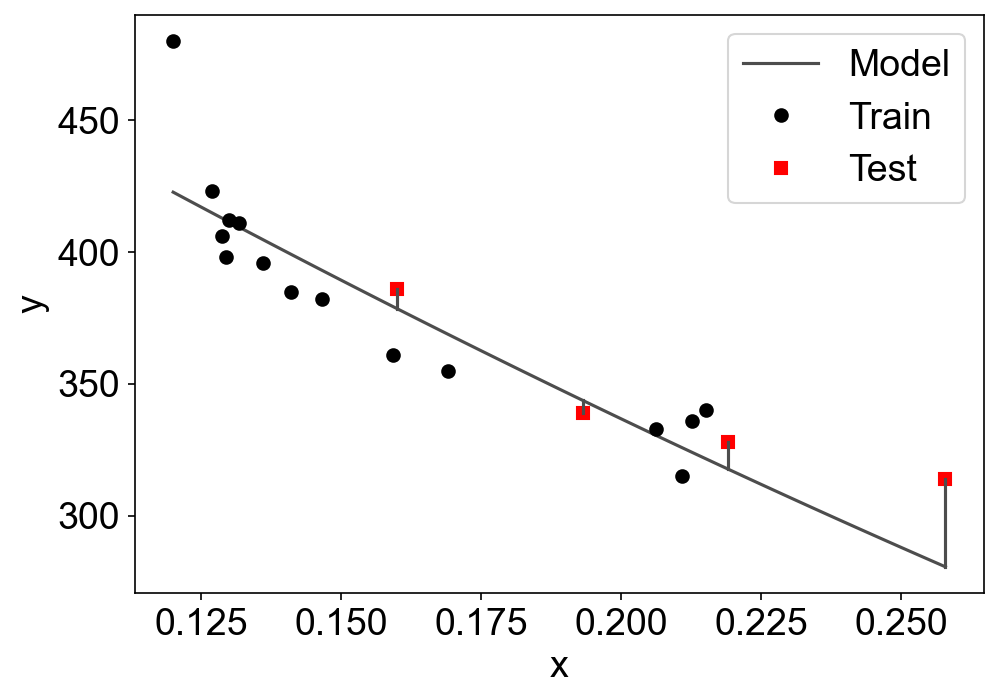

{'model': ElasticNet(),
 'rmse': 27.225254775679854,
 'rmse_std': 13.311586631276176,
 'baseline_rmse': 43.77663537385113,
 'baseline_rmse_std': 13.392261273270911,
 'corr': (-0.8796274060670326, -0.5754582838798652, -0.5195902101659091),
 'corr_std': (0.028415824182478906, 0.09779936040871022, 0.13192097539157877),
 'percent_error': 5.714672316916957,
 'percent_error_std': 2.319083428044329,
 'r2_score': -0.29385222958690155,
 'r2_score_std': 3.489676154544325,
 'r2_score_manual': 0.6132243300932231,
 'features': ('var_q_c20_c365_c3_ah',
  'var_q_c20_c56_c3_ah',
  'var_q_c20_c159_c3_ah')}

In [307]:
def train_and_test_model(df, xvars, yvar, 
                         to_plot=1, model=None, num_experiments=None,
                         log=False, square=False, sqrt=False):
    """
    Train and test a univariate linear regression model with cross-validation
    
    Args:
      df is a Pandas DataFrame object
      xvars is a list of strings (the feature names)
      yvar is a string (the label name)
      to_plot : make debug plots if true
      
    Returns:
      a dictionary holding model outputs
    """    
    # Fraction of samples reserved for model testing
    # e.g. 0.2 means 20% of samples reserved. In the 
    # context of cross-validation, this would be 
    # equivalent to a 5-fold cross-validation. The 
    # cross-validation we end up doing is not exactly
    # 5-fold cross-validation since we introduce random
    # sampling and many many repeats
    TEST_SIZE = 0.2
    
    # Number of trials
    num_experiments = num_experiments or 100
    
    # Unpack and filter data
    xvars = [xvars] if isinstance(xvars, str) else xvars
    # Create a temporary df to filter NaNs only from the columns we use
    xyvars = xvars + [yvar]
    df_nonans = df[xyvars].dropna()
    if log is True:
        df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))
    if square is True:
        df_nonans = df_nonans.apply(lambda x: x**2)
    if sqrt is True:
        df_nonans = df_nonans.apply(lambda x: np.sqrt(abs(x)))
    
    X = df_nonans[xvars].values
    y = df_nonans[yvar].values
        
    percent_error_list = []
    r2_score_list = []
    rmse_list = []
    baseline_rmse_list = []
    intercept_list = []
    coef_list = []
    corr_list = []
    
    has_plotted = 0
    
    for idx in range(num_experiments):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=TEST_SIZE)

        # apply standard scaler (fit only on train, transform both train and test)
        # keep originals for pltos
        X_train_original = X_train
        X_test_original = X_test
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
        (model, corr) = build_model(X_train, y_train, model)
        
        y_pred = model.predict(X_test)
        y_train_mean = np.mean(y_train)
        
        r2_score = model.score(X_test, y_test)
        
        if log is True:
            y_train = np.exp(y_train)
            y_pred = np.exp(y_pred)
            y_test = np.exp(y_test)
            y_train_mean = np.exp(y_train_mean)
        if square is True:
            y_train = np.sqrt(y_train)
            y_pred = np.sqrt(y_pred)
            y_test = np.sqrt(y_test)
            y_train_mean = np.sqrt(y_train_mean)
        if sqrt is True:
            y_train = (y_train)**2
            y_pred = (y_pred)**2
            y_test = (y_test)**2
            y_train_mean = (y_train_mean)**2

        rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
        percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
        baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))
        
        rmse_list.append(rmse)
        percent_error_list.append(percent_error)
        r2_score_list.append(r2_score)
        baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
        corr_list.append(corr)
    
        # Give a visual into the cross-validation process
        if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
            has_plotted = 1
            
            x_fit = np.linspace(np.min(X), np.max(X), 100)
            x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
            y_fit = model.predict(x_fit_trans)
            if log is True:
                y_fit = np.exp(y_fit)
            if square is True:
                y_fit = np.sqrt(y_fit)
            if sqrt is True:
                y_fit = y_fit ** 2
            plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
            plt.plot(X_train_original, y_train, 'o', color='k')
            plt.plot(X_test_original, y_test, 's', color='r')
            
            for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
                plt.plot([this_x, this_x], 
                         [this_y, this_ypred], 
                         label='', color=(0.3, 0.3, 0.3))
                
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend(['Model', 'Train', 'Test'])
            plt.show()
    
    # Package the output
    final_model = model
    # Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)
        
    final_rmse = np.mean(rmse_list)
    final_rmse_std = np.std(rmse_list)
    
    final_baseline_rmse = np.mean(baseline_rmse_list)
    final_baseline_rmse_std = np.std(baseline_rmse_list)
    
    # Column mean and column std of a list of tuples
    final_corr = tuple(map(np.mean, zip(*corr_list)))
    final_corr_std = tuple(map(np.std, zip(*corr_list)))
    
    final_percent_error = np.mean(percent_error_list)
    final_percent_error_std = np.std(percent_error_list)
    
#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
    final_r2_score = np.mean(r2_score_list)
    final_r2_score_std = np.std(r2_score_list)
    
    model_output_dict = dict()
    model_output_dict['model'] = final_model
    model_output_dict['rmse'] = final_rmse
    model_output_dict['rmse_std'] = final_rmse_std
    model_output_dict['baseline_rmse'] = final_baseline_rmse
    model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
    model_output_dict['corr'] = final_corr
    model_output_dict['corr_std'] = final_corr_std
    model_output_dict['percent_error'] = final_percent_error
    model_output_dict['percent_error_std'] = final_percent_error_std
    model_output_dict['r2_score'] = final_r2_score
    model_output_dict['r2_score_std'] = final_r2_score_std
    model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
    model_output_dict['features'] = tuple(xvars)
    
    return model_output_dict

# Test
# one feature
# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1)

# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1,
#                      log=True)

# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1,
#                      square=True)

train_and_test_model(df, 
                     "var_q_c20_c365_c3_ah", 
                     'cycles_to_80_pct', 
                     to_plot=1,
                     sqrt=True)

# multiple features
train_and_test_model(df, 
                     ["var_q_c20_c365_c3_ah", "var_q_c20_c56_c3_ah", "var_q_c20_c159_c3_ah"], 
                     'cycles_to_80_pct', 
                     to_plot=1,
                     model=ElasticNet())

# Single feature

## Set up and fit/predict/score

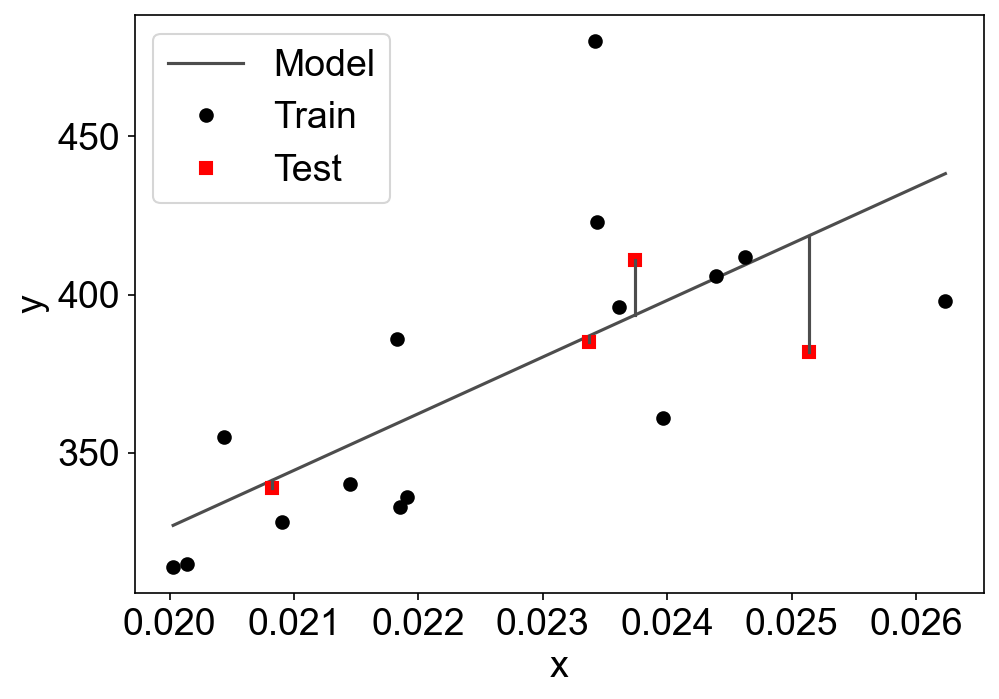

In [9]:
# Set the y-variable (the output the model is trying to predict)
yvar80 = 'cycles_to_80_pct'
yvar70 = 'cycles_to_70_pct'
yvar60 = 'cycles_to_60_pct'
yvar50 = 'cycles_to_50_pct'
yvar = yvar80

# Gather a list of modeled results. 
# Each element of the list holds all modeled results for a particular cycle
results_list = []

# First take care of the formation delta V signal, which only exists for the initial cycle
xvar = 'form_6hr_rest_delta_voltage_v'

model_output_dict = train_and_test_model(df, xvar, yvar)
model = model_output_dict['model']

results_dict = dict()
results_dict['cycle_index'] = 0 #
results_dict[xvar] = model_output_dict

results_list.append(results_dict)

Working on cycle 3...


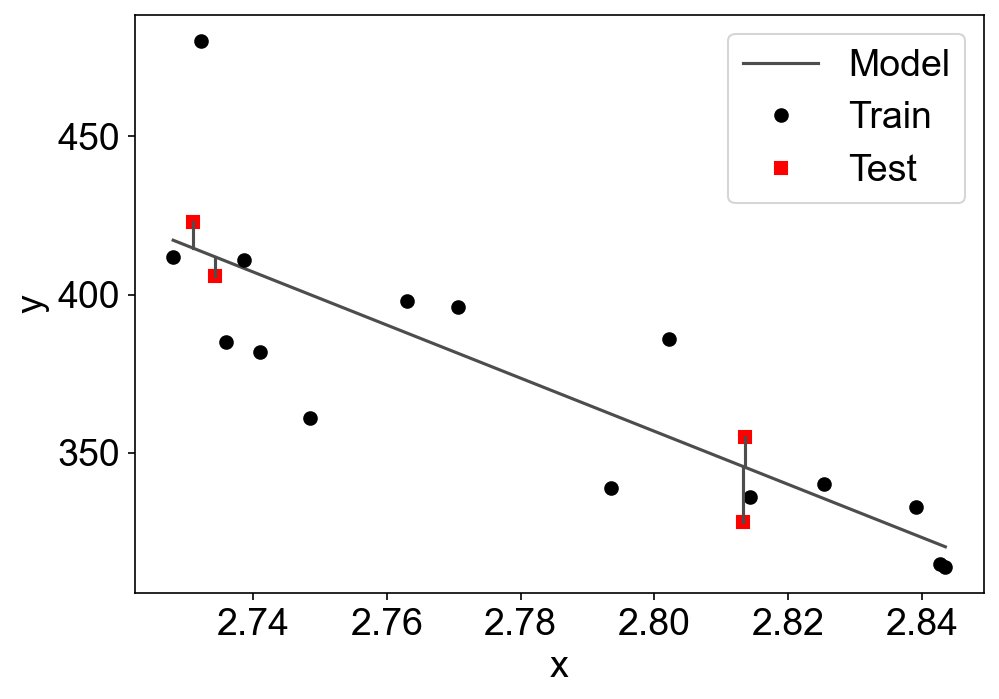

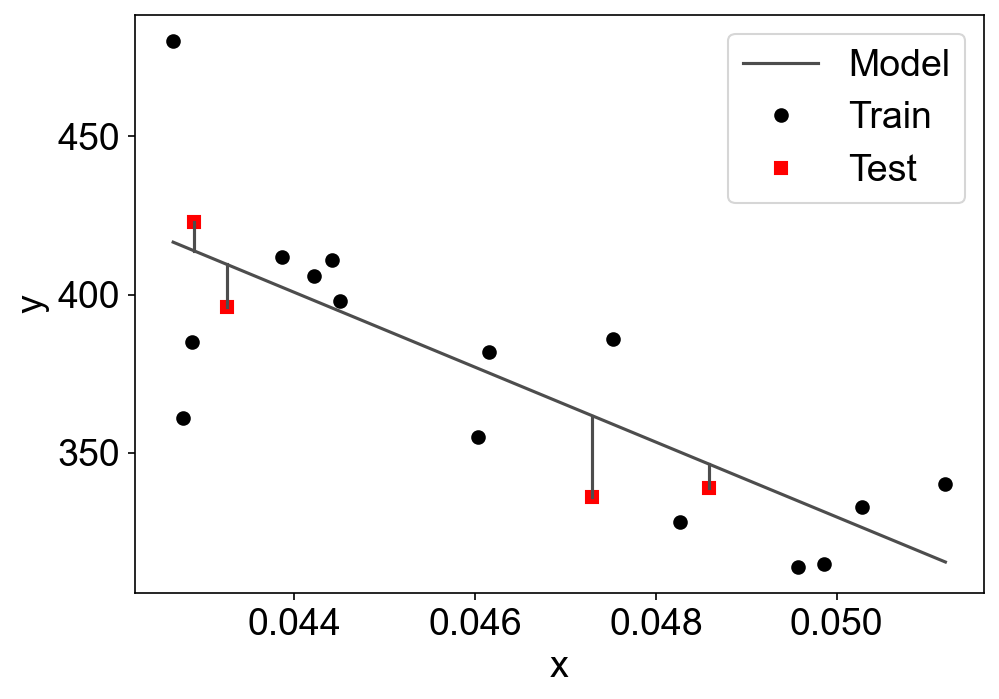

Working on cycle 56...


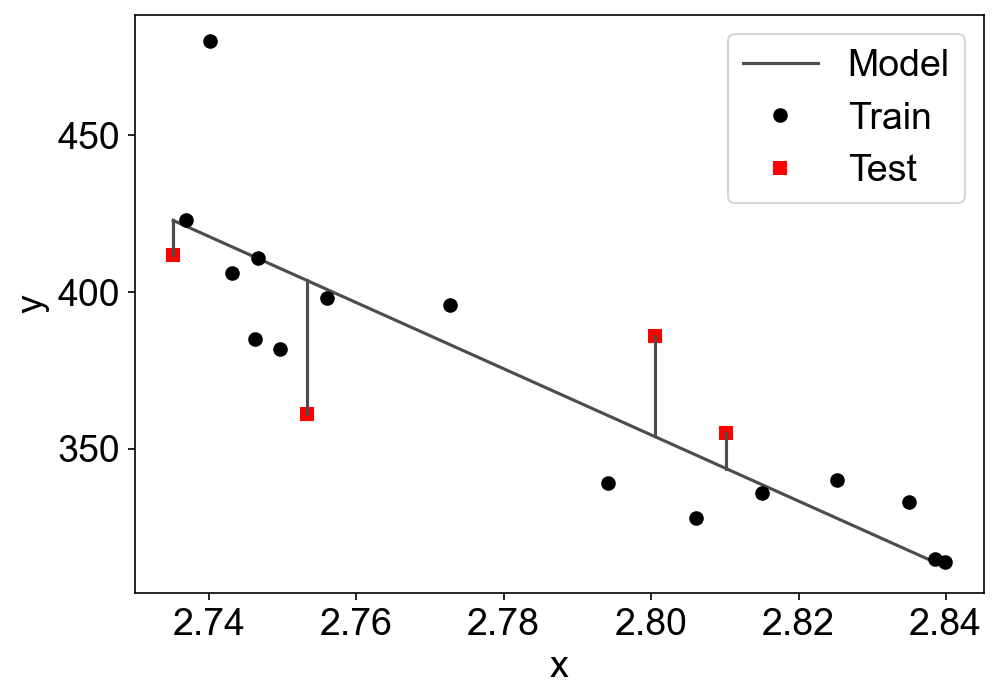

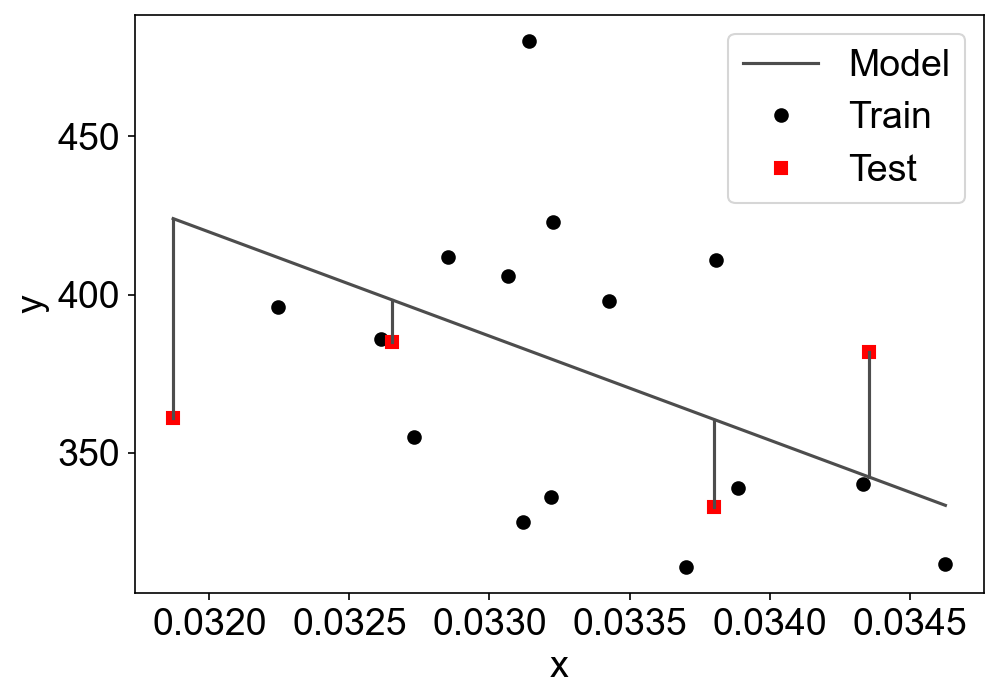

Working on cycle 159...


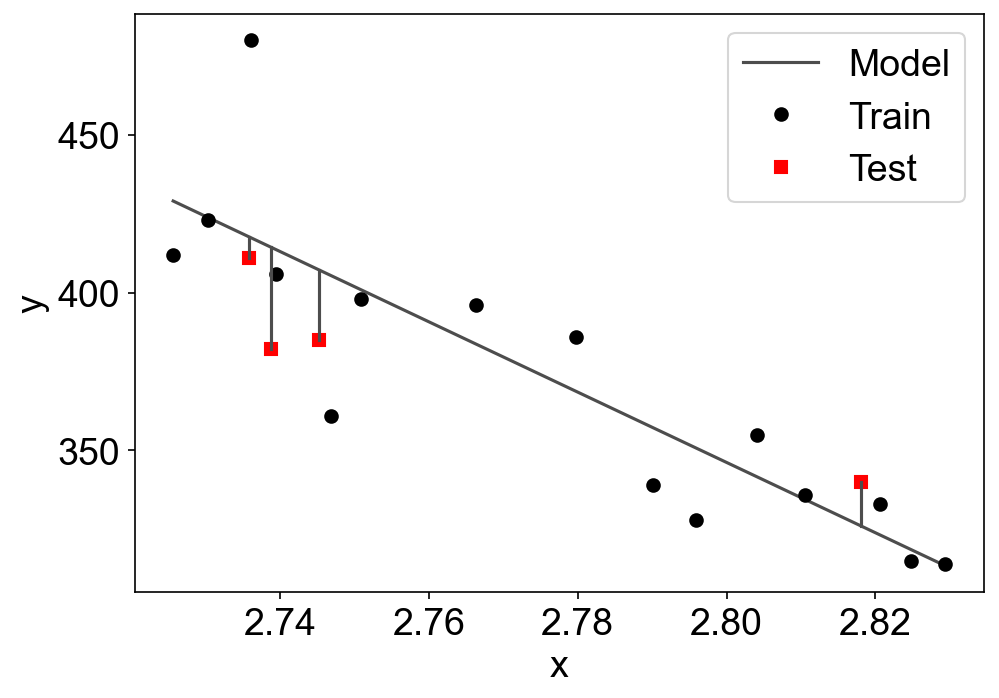

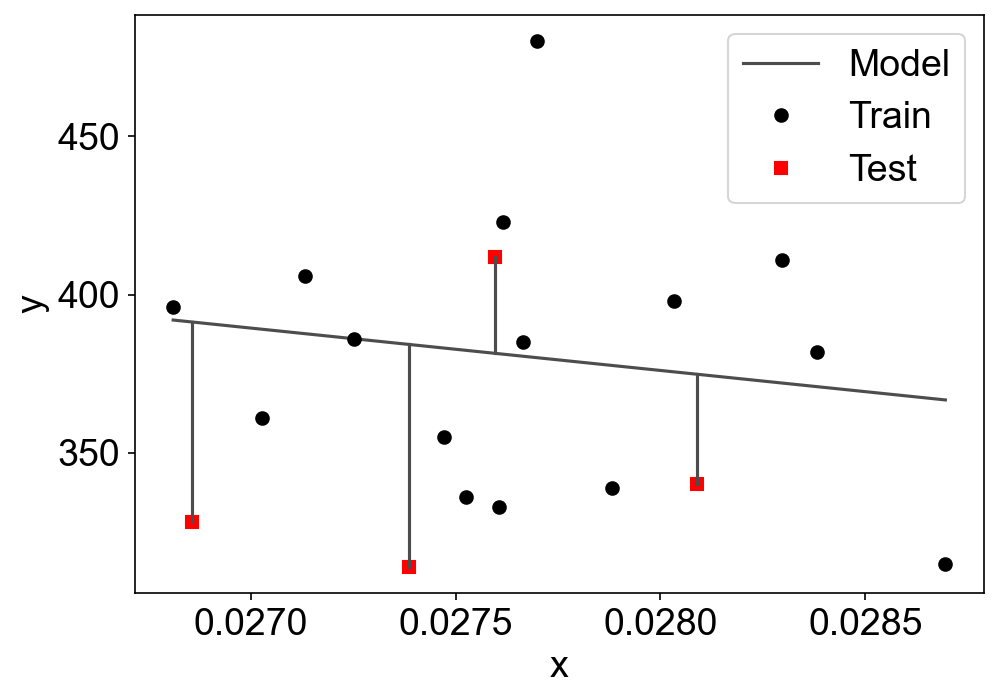

Working on cycle 262...


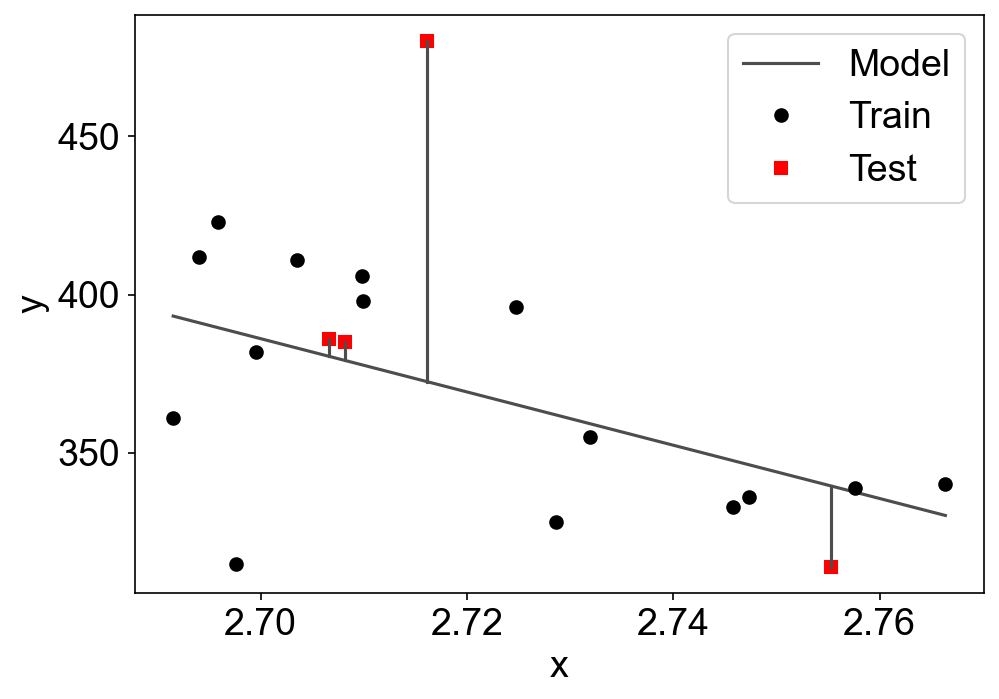

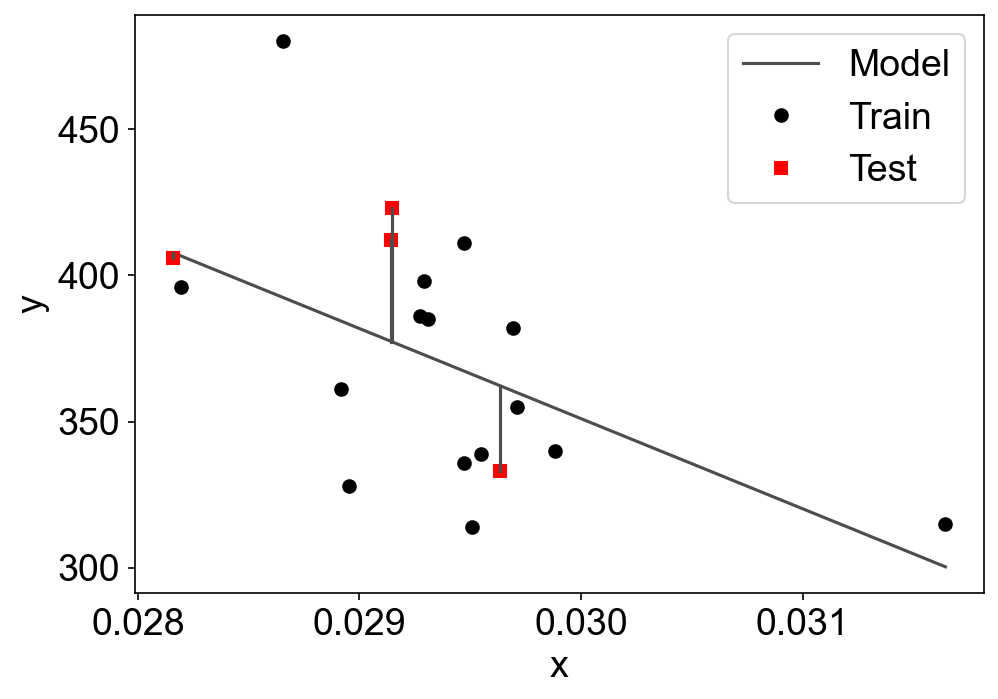

Working on cycle 365...


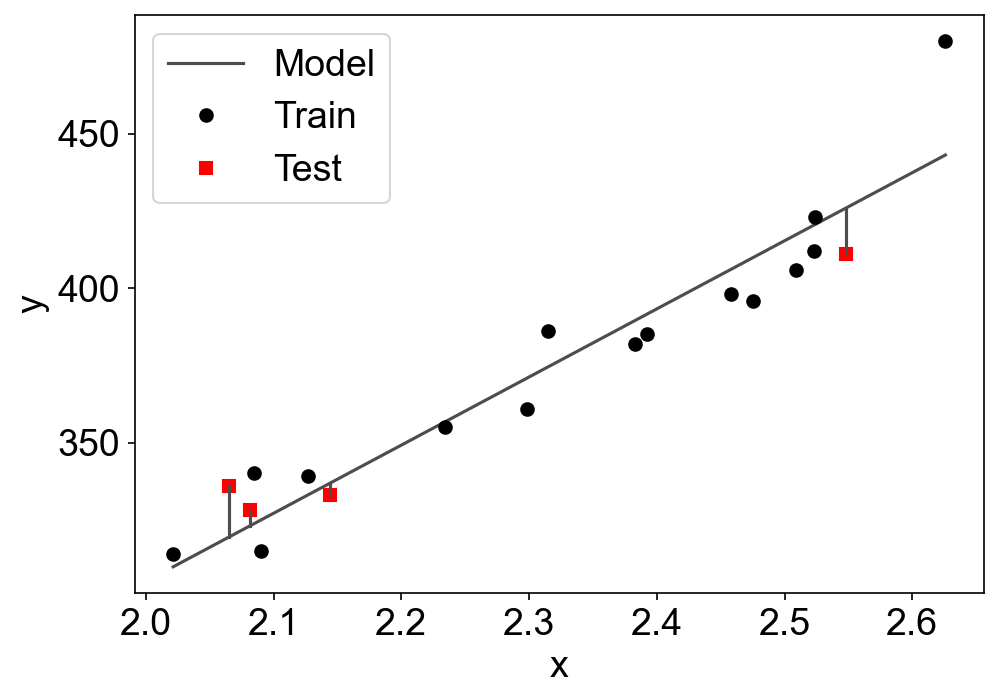

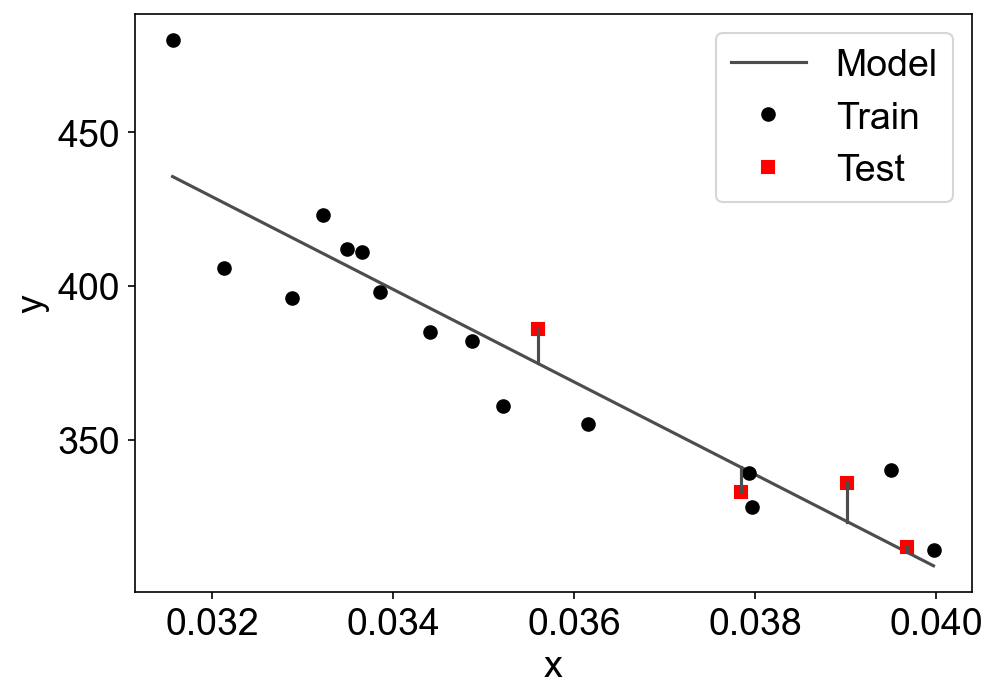

Done.


In [10]:
# Now take care of the rest of the signals. These signals exist for multiple cycles since 
# they exist at each RPT. So we will loop through the valid cycle indices and repeat this 
# process.

cycle_target_list = [3, 56, 159, 262, 365]

for cycle_idx in cycle_target_list:
    
    print(f'Working on cycle {cycle_idx}...')
    
    # Assemble x variables of interest
    xvar_array = [f'esoh_c{cycle_idx}_Cn',
                  f'dcr_10s_5_soc_at_c{cycle_idx}',
                  f'var_q_c{cycle_idx}_c3']
    
    results_dict = dict()
    results_dict['cycle_index'] = cycle_idx
    
    # Loop over x-variables
    for xvar in xvar_array:

        if not xvar in df.columns:
            continue
        
        model_output_dict = train_and_test_model(df, xvar, yvar)
        
        model = model_output_dict['model']

        if '_Cn' in xvar:
            xvar_label = 'Cn'
        if 'dcr_10s_5_soc' in xvar:
            xvar_label = 'dcr_10s_5_soc'
        if 'var_q' in xvar:
            xvar_label = 'var_q'
    
        results_dict[xvar_label] = model_output_dict
        
    results_list.append(results_dict)      
    
print('Done.')
    

Take a look at the results list variable.

It is a list of dictionaries. Each dictionary holds the output for a single cycle index.

In [11]:
results_list

[{'cycle_index': 0,
  'form_6hr_rest_delta_voltage_v': {'model': LinearRegression(),
   'rmse': 29.284153934945245,
   'rmse_std': 11.819992674579982,
   'baseline_rmse': 41.55728235437432,
   'baseline_rmse_std': 12.624272695747145,
   'corr': (0.6973669202831995,),
   'corr_std': (0.05575106005082599,),
   'percent_error': 6.382016790470555,
   'percent_error_std': 1.9191818447160855,
   'r2_score': 0.002012221271045469,
   'r2_score_std': 1.2745436378566588,
   'r2_score_manual': 0.5034407412298341,
   'features': ('form_6hr_rest_delta_voltage_v',)}},
 {'cycle_index': 3,
  'Cn': {'model': LinearRegression(),
   'rmse': 21.107314379176263,
   'rmse_std': 10.436659333021353,
   'baseline_rmse': 43.60481725370511,
   'baseline_rmse_std': 12.728448497749852,
   'corr': (-0.8390713445217456,),
   'corr_std': (0.03684624720713641,),
   'percent_error': 4.5321620375529115,
   'percent_error_std': 1.7667818739136574,
   'r2_score': 0.31752045947703655,
   'r2_score_std': 0.7705845977592121,

## Re-package the data to become easily plottable

Repackage the data to index by feature, which makes it easier for plotting.

There is probably a more "pandas-y" way to do this.

In [12]:
# Get a list of unique x-variable labels
unique_keys = set()
for result_dict in results_list:
    for key in result_dict.keys():
        unique_keys.add(key)
unique_keys.remove('cycle_index')

# Assemble the outputs into a dictionary
output_dict = dict()
for key in unique_keys:
    
    cycle_list = []
    rmse_list = []
    rmse_std_list = []
    corr_list = []
    corr_std_list = []
    percent_error_list = []
    percent_error_std_list = []
    
    for result_dict in results_list:

        cycle_list.append(result_dict['cycle_index'])    
        
        if not key in result_dict:
            rmse_list.append(np.nan)
            rmse_std_list.append(np.nan)
            corr_list.append(np.nan)
            corr_std_list.append(np.nan)
            percent_error_list.append(np.nan)
            percent_error_std_list.append(np.nan)
            continue

        rmse_list.append(result_dict[key]['rmse'])
        rmse_std_list.append(result_dict[key]['rmse_std'])
        if len(result_dict[key]['corr']) == 1:
            corr_list.append(result_dict[key]['corr'][0])
            corr_std_list.append(result_dict[key]['corr_std'][0])
        percent_error_list.append(result_dict[key]['percent_error'])
        percent_error_std_list.append(result_dict[key]['percent_error_std'])
        
        
    this_result = dict()
    this_result['cycle_index'] = cycle_list
    this_result['rmse'] = rmse_list
    this_result['rmse_std'] = rmse_std_list
    this_result['corr'] = corr_list
    this_result['corr_std'] = corr_std_list
    this_result['percent_error'] = percent_error_list
    this_result['percent_error_std'] = percent_error_std_list
    
    output_dict[key] = this_result
    
# The output dictionary is now indexed by feature
output_dict

{'dcr_10s_5_soc': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [nan,
   26.21159778200605,
   41.25819689865889,
   46.92389856257761,
   37.84715682440617,
   17.61604964558015],
  'rmse_std': [nan,
   11.545653074727152,
   12.171643144010885,
   14.020559659880544,
   12.625152128186205,
   7.235204777512577],
  'corr': [nan,
   -0.7984719876618862,
   -0.34036541849936214,
   -0.04024485770013756,
   -0.5638194468382267,
   -0.9327355176581642],
  'corr_std': [nan,
   0.03858093963021809,
   0.07412058104333262,
   0.13573681202747548,
   0.04291534263603733,
   0.012151252227664082],
  'percent_error': [nan,
   5.820380833579903,
   9.87802978805974,
   11.39548872385546,
   8.846269859839962,
   3.764806261357939],
  'percent_error_std': [nan,
   2.1163174758007854,
   2.5918156003353983,
   3.2677963839177715,
   2.817819223813626,
   1.2779912821219295]},
 'Cn': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [nan,
   21.107314379176263,
   24.008162655449823,
   2

## Visualize the results

In [13]:
# Create another dictionary of labels
label_dict = dict()
label_dict['var_q'] = '$\Delta Q$'
label_dict['Cn'] = '$C_n$'
label_dict['dcr_10s_5_soc'] = '$R_{10s, 5\%SOC}$'
label_dict['form_6hr_rest_delta_voltage_v'] = '$\Delta V_{rest, 6hr}$'

<Figure size 1050x750 with 0 Axes>

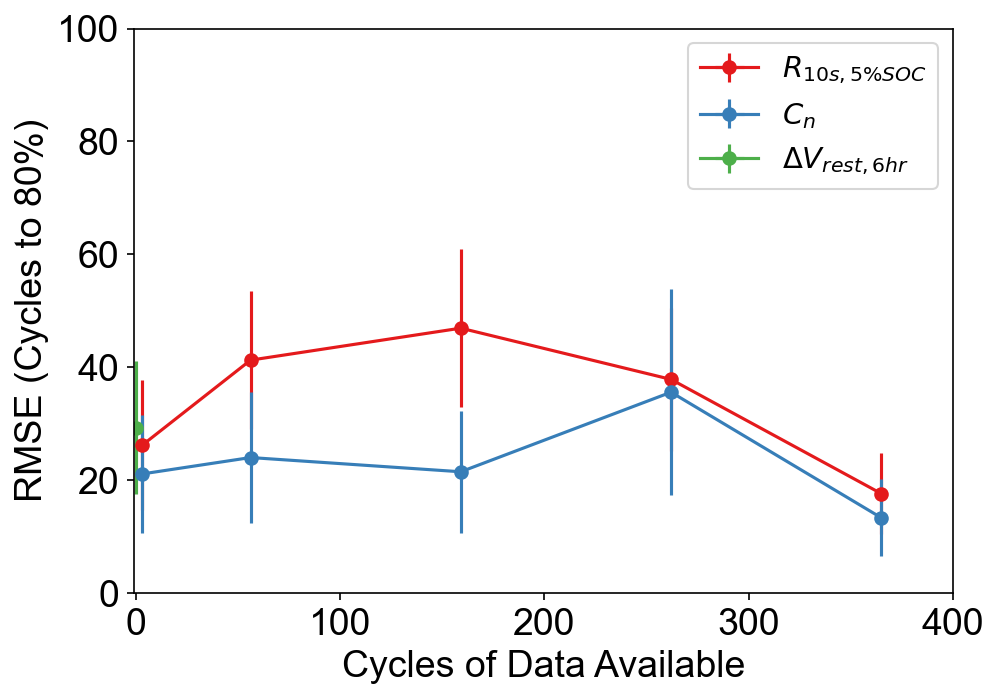

<Figure size 1050x750 with 0 Axes>

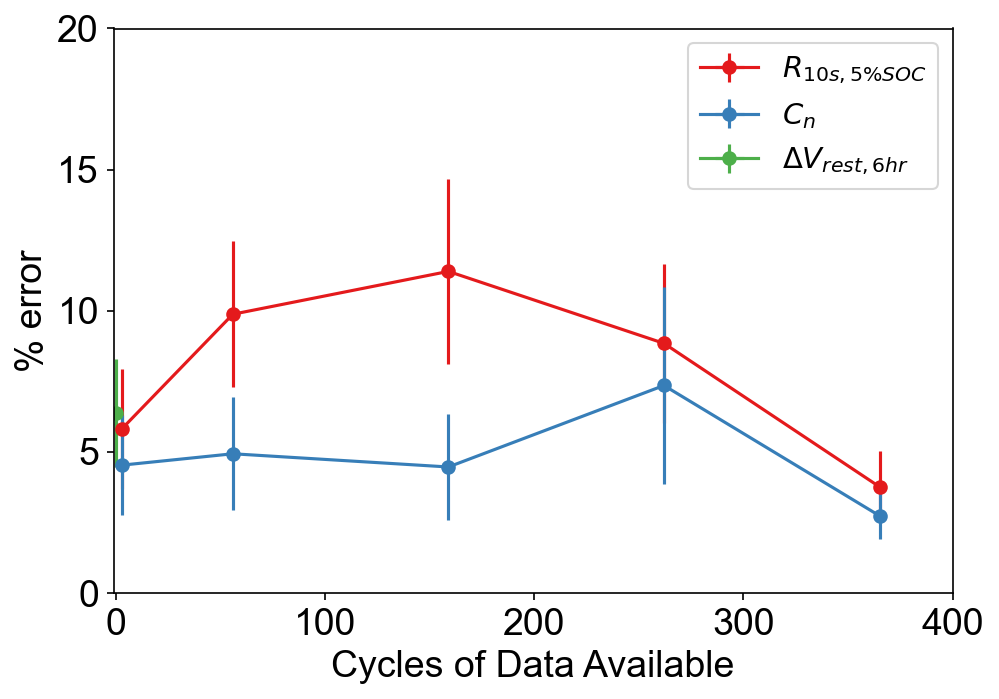

<Figure size 1050x750 with 0 Axes>

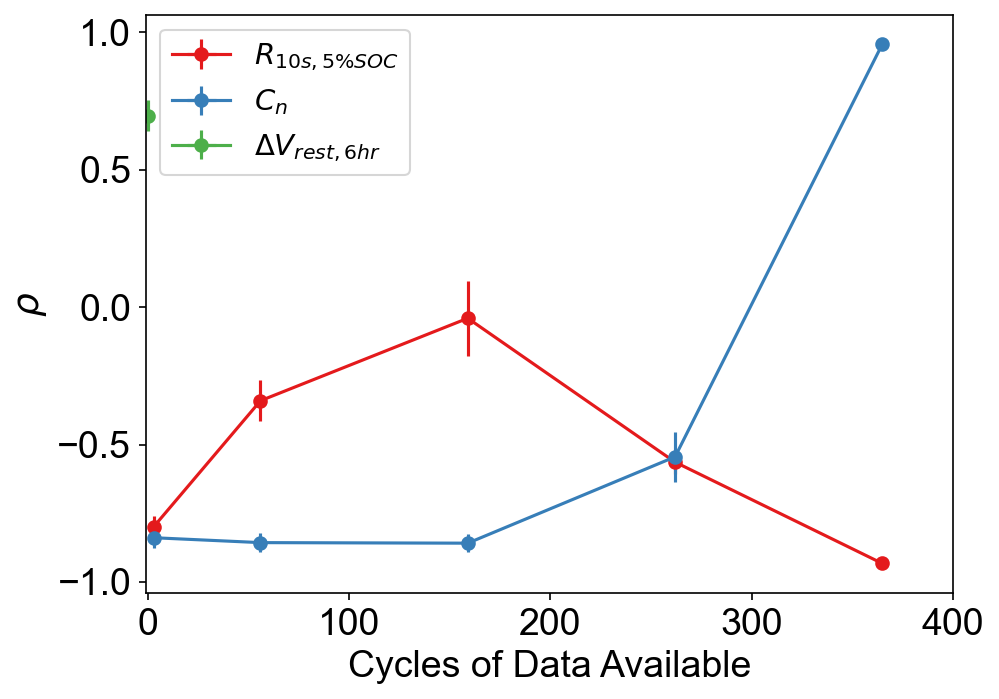

In [14]:
# Unpack and plot the dictionary of outputs
plt.figure()
fig, ax = plt.subplots()

labels = ["c%.0f" % number for number in output_dict[list(output_dict.keys())[0]]['cycle_index']]
labels[0] = "         Form."
    
# RMSE error (cycles to 70%)
for idx, key in enumerate(output_dict):

    x = output_dict[key]['cycle_index']
    y = output_dict[key]['rmse']
    error = output_dict[key]['rmse_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel('RMSE (Cycles to 80%)')
plt.xlim((-1, 400))
plt.ylim((0, 100))
plt.legend(fontsize=14)

# Percent error
plt.figure()
fig, ax = plt.subplots()

for idx, key in enumerate(output_dict):
    
    x = output_dict[key]['cycle_index']
    y = output_dict[key]['percent_error']
    error = output_dict[key]['percent_error_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel('% error')
plt.ylim((0, 20))
plt.xlim((-1, 400))
plt.legend(fontsize=14)


# Correlation coefficient evolution
plt.figure()
fig, ax = plt.subplots()

for idx, key in enumerate(output_dict):
    
    x = output_dict[key]['cycle_index']
    y = output_dict[key]['corr']
    error = output_dict[key]['corr_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel(r'$\rho$')
plt.xlim((-1, 400))
plt.legend(fontsize=14)

# Multiple features from formation

## Data analysis

In [92]:
yvar = yvar50

Select relevant formation features

In [93]:
form_select = lambda x: x.startswith("form_") and "trace" not in x and "rebound" not in x
form_features = list(filter(form_select, df.columns))
label_select = lambda x: x.startswith("cycles_to_")
labels = list(filter(label_select, df.columns))
df_form = df[form_features + labels]
df_form.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 31 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   form_first_discharge_capacity_below_3p2v_ah  19 non-null     float64
 1   form_last_charge_voltage_after_1s            19 non-null     float64
 2   form_last_charge_voltage_after_10s           19 non-null     float64
 3   form_last_charge_voltage_after_60s           19 non-null     float64
 4   form_first_charge_capacity_ah                19 non-null     float64
 5   form_first_discharge_capacity_ah             19 non-null     float64
 6   form_first_cycle_efficiency                  19 non-null     float64
 7   form_final_discharge_capacity_ah             19 non-null     float64
 8   form_6hr_rest_delta_voltage_v_0_to_1_hr      19 non-null     float64
 9   form_6hr_rest_delta_voltage_v_0_to_2_hr      19 non-null     float64
 10  form

In [164]:
df_form_sq = df_form.apply(lambda x: x**2).rename(lambda s: s + "_squared", axis="columns")
df_form_sq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 31 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   form_first_discharge_capacity_below_3p2v_ah_squared  19 non-null     float64
 1   form_last_charge_voltage_after_1s_squared            19 non-null     float64
 2   form_last_charge_voltage_after_10s_squared           19 non-null     float64
 3   form_last_charge_voltage_after_60s_squared           19 non-null     float64
 4   form_first_charge_capacity_ah_squared                19 non-null     float64
 5   form_first_discharge_capacity_ah_squared             19 non-null     float64
 6   form_first_cycle_efficiency_squared                  19 non-null     float64
 7   form_final_discharge_capacity_ah_squared             19 non-null     float64
 8   form_6hr_rest_delta_voltage_v_0_to_1_hr_squared      19 non-null     flo

In [177]:
df_form_plus_sq = pd.concat([df_form, df_form_sq], axis=1)
df_form_plus_sq.head()

form_first_discharge_capacity_below_3p2v_ah  \
0                                     0.077820   
1                                     0.073791   
2                                     0.074725   
3                                     0.069433   
4                                     0.073127   

   form_last_charge_voltage_after_1s  form_last_charge_voltage_after_10s  \
0                           3.393505                            3.403936   
1                           3.401924                            3.412256   
2                           3.398755                            3.409052   
3                           3.400189                            3.410498   
4                           3.396888                            3.407243   

   form_last_charge_voltage_after_60s  form_first_charge_capacity_ah  \
0                            3.420587                       2.755302   
1                            3.428007                       2.698299   
2                            3.424840                       2.713403   
3                            3.426320                       2.696613   
4                            3.423244                       2.713639   

   form_first_discharge_capacity_ah  form_first_cycle_efficiency  \
0                          2.312734                     0.839376   
1                          2.313851                     0.857522   
2                          2.309945                     0.851309   
3                          2.310417                     0.856785   
4                          2.330587                     0.858842   

   form_final_discharge_capacity_ah  form_6hr_rest_delta_voltage_v_0_to_1_hr  \
0                          2.367225                                 0.011104   
1                          2.363418                                 0.010694   
2                          2.362668                                 0.011531   
3                          2.356018                                 0.010730   
4                          2.381257                                 0.011573   

   form_6hr_rest_delta_voltage_v_0_to_2_hr  \
0                                 0.014412   
1                                 0.013741   
2                                 0.015044   
3                                 0.013928   
4                                 0.015010   

   form_6hr_rest_delta_voltage_v_0_to_3_hr  \
0                                 0.016395   
1                                 0.015612   
2                                 0.017074   
3                                 0.015780   
4                                 0.017089   

   form_6hr_rest_delta_voltage_v_0_to_4_hr  \
0                                 0.017794   
1                                 0.017002   
2                                 0.018645   
3                                 0.017201   
4                                 0.018494   

   form_6hr_rest_delta_voltage_v_0_to_5_hr  \
0                                 0.018984   
1                                 0.018085   
2                                 0.019790   
3                                 0.018138   
4                                 0.019764   

   form_6hr_rest_delta_voltage_v_0_to_6_hr  \
0                                 0.019909   
1                                 0.018962   
2                                 0.020716   
3                                 0.019097   
4                                 0.020793   

   form_6hr_rest_delta_voltage_v_1_to_6_hr  \
0                                 0.008731   
1                                 0.008188   
2                                 0.009108   
3                                 0.008275   
4                                 0.009128   

   form_6hr_rest_delta_voltage_v_2_to_6_hr  \
0                                 0.005468   
1                                 0.005158   
2                                 0.005626   
3                                 0.005127   
4                             

Look for correlations

In [94]:
df_form.corr()[yvar50].sort_values(ascending=False)

cycles_to_50_pct                               1.000000
cycles_to_60_pct                               0.995579
cycles_to_70_pct                               0.976940
cycles_to_80_pct                               0.971337
form_last_charge_voltage_after_60s             0.802370
form_c20_charge_right_peak_v_per_ah            0.772470
form_6hr_rest_delta_voltage_v_0_to_3_hr        0.730636
form_6hr_rest_delta_voltage_v_0_to_4_hr        0.729484
form_6hr_rest_delta_voltage_v_0_to_5_hr        0.726760
form_6hr_rest_delta_voltage_v_0_to_2_hr        0.721277
form_6hr_rest_delta_voltage_v_0_to_6_hr        0.711559
form_6hr_rest_delta_voltage_v                  0.710422
form_6hr_rest_delta_voltage_v_0_to_1_hr        0.698247
form_6hr_rest_delta_voltage_v_1_to_6_hr        0.651170
form_6hr_rest_delta_voltage_v_2_to_6_hr        0.565207
form_6hr_rest_delta_voltage_v_3_to_6_hr        0.505149
form_6hr_rest_delta_voltage_v_4_to_6_hr        0.467371
form_6hr_rest_delta_voltage_v_5_to_6_hr        0

Select and plot features with abs(corr) > 0.6

In [95]:
high_corr = lambda name: abs(df_form.corr()[yvar][name]) > 0.6
high_corr_form_features = list(filter(high_corr, form_features))
high_corr_form_features

['form_first_discharge_capacity_below_3p2v_ah',
 'form_last_charge_voltage_after_1s',
 'form_last_charge_voltage_after_10s',
 'form_last_charge_voltage_after_60s',
 'form_first_discharge_capacity_ah',
 'form_first_cycle_efficiency',
 'form_6hr_rest_delta_voltage_v_0_to_1_hr',
 'form_6hr_rest_delta_voltage_v_0_to_2_hr',
 'form_6hr_rest_delta_voltage_v_0_to_3_hr',
 'form_6hr_rest_delta_voltage_v_0_to_4_hr',
 'form_6hr_rest_delta_voltage_v_0_to_5_hr',
 'form_6hr_rest_delta_voltage_v_0_to_6_hr',
 'form_6hr_rest_delta_voltage_v_1_to_6_hr',
 'form_c20_charge_right_peak_v_per_ah',
 'form_6hr_rest_delta_voltage_v',
 'form_6hr_rest_voltage_v',
 'form_6hr_rest_mv_per_sec_initial']

In [97]:
very_high_corr = lambda name: abs(df_form.corr()[yvar][name]) > 0.77
very_high_corr_form_features = list(filter(very_high_corr, form_features))
very_high_corr_form_features

['form_first_discharge_capacity_below_3p2v_ah',
 'form_last_charge_voltage_after_1s',
 'form_last_charge_voltage_after_60s',
 'form_first_discharge_capacity_ah',
 'form_first_cycle_efficiency',
 'form_c20_charge_right_peak_v_per_ah']

In [220]:
df_form[high_corr_form_features].corr()["form_first_discharge_capacity_ah"].sort_values()

form_last_charge_voltage_after_60s            -0.980428
form_6hr_rest_delta_voltage_v_0_to_3_hr       -0.916951
form_6hr_rest_delta_voltage_v_0_to_2_hr       -0.915978
form_6hr_rest_delta_voltage_v_0_to_4_hr       -0.913766
form_6hr_rest_delta_voltage_v_0_to_1_hr       -0.904858
form_6hr_rest_delta_voltage_v_0_to_5_hr       -0.903710
form_c20_charge_right_peak_v_per_ah           -0.898403
form_6hr_rest_delta_voltage_v_0_to_6_hr       -0.893952
form_6hr_rest_delta_voltage_v                 -0.890137
form_6hr_rest_delta_voltage_v_1_to_6_hr       -0.789071
form_6hr_rest_mv_per_sec_initial               0.871221
form_6hr_rest_voltage_v                        0.890137
form_last_charge_voltage_after_10s             0.937693
form_first_discharge_capacity_below_3p2v_ah    0.994841
form_last_charge_voltage_after_1s              0.998766
form_first_cycle_efficiency                    0.999884
form_first_discharge_capacity_ah               1.000000
Name: form_first_discharge_capacity_ah, dtype: f

<ipython-input-60-c858b667374c>:11: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
<ipython-input-60-c858b667374c>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")
<ipython-input-60-c858b667374c>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


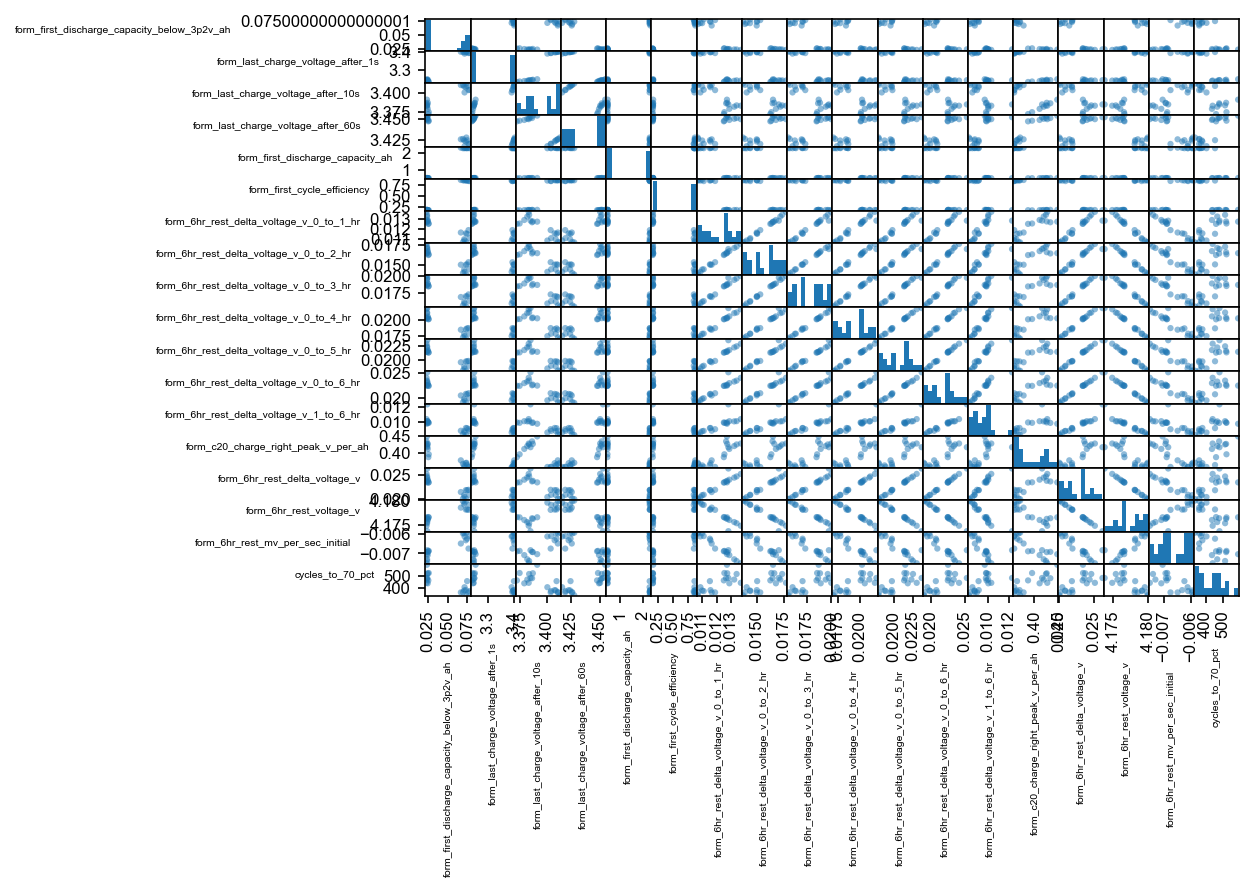

In [60]:
from pandas.plotting import scatter_matrix
plt.rcParams['axes.labelsize'] = 5
axes = scatter_matrix(df_form[high_corr_form_features + [yvar]])

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    
OUTPUT_DIR = "code/imgs/"
plt.tight_layout()
plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")

In [61]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
config_plots()

### with log

In [98]:
df_form_log = df_form.apply(lambda x: np.log(abs(x)))
df_form_log.describe()

form_first_discharge_capacity_below_3p2v_ah  \
count                                    19.000000   
mean                                     -3.198979   
std                                       0.564067   
min                                      -3.766923   
25%                                      -3.729466   
50%                                      -3.649625   
75%                                      -2.626924   
max                                      -2.553354   

       form_last_charge_voltage_after_1s  form_last_charge_voltage_after_10s  \
count                          19.000000                           19.000000   
mean                            1.198703                            1.222002   
std                             0.023588                            0.004068   
min                             1.174555                            1.215440   
25%                             1.177094                            1.218782   
50%                             1.179177                            1.221083   
75%                             1.223027                            1.226052   
max                             1.224341                            1.227374   

       form_last_charge_voltage_after_60s  form_first_charge_capacity_ah  \
count                           19.000000                      19.000000   
mean                             1.234841                       1.003142   
std                              0.004154                       0.012057   
min                              1.228971                       0.988929   
25%                              1.231004                       0.994866   
50%                              1.237599                       0.998291   
75%                              1.238623                       1.009378   
max                              1.239590                       1.037936   

       form_first_discharge_capacity_ah  form_first_cycle_efficiency  \
count                         19.000000                    19.000000   
mean                           0.008368                    -0.994774   
std                            0.812216                     0.816364   
min                           -0.759595                    -1.784166   
25%                           -0.741329                    -1.746586   
50%                           -0.728661                    -1.722820   
75%                            0.838672                    -0.157774   
max                            0.850454                    -0.140043   

       form_final_discharge_capacity_ah  \
count                         19.000000   
mean                           0.860630   
std                            0.004333   
min                            0.854034   
25%                            0.858194   
50%                            0.860109   
75%                            0.862090   
max                            0.869140   

       form_6hr_rest_delta_voltage_v_0_to_1_hr  \
count                                19.000000   
mean                                 -4.416723   
std                                   0.078911   
min                                  -4.538118   
25%                                  -4.481583   
50%                                  -4.382669   
75%                                  -4.360943   
max                                  -4.293166   

       form_6hr_rest_delta_voltage_v_0_to_2_hr  \
count                                19.000000   
mean                                 -4.154705   
std                                   0.081232   
min                                  -4.287379   
25%                                  -4.219624   
50%                                  -4.119745   
75%                                  -4.093166   
max                                  -4.035049   

       form_6hr_rest_delta_voltage_v_0_to_3_hr  \
count                                19.000000   
mean                                 -4.027465   
std                      

In [99]:
df_form_log.corr()[yvar].sort_values(ascending=False)

cycles_to_50_pct                               1.000000
cycles_to_60_pct                               0.994038
cycles_to_70_pct                               0.973508
cycles_to_80_pct                               0.973244
form_last_charge_voltage_after_60s             0.811610
form_c20_charge_right_peak_v_per_ah            0.773500
form_6hr_rest_delta_voltage_v_0_to_4_hr        0.757980
form_6hr_rest_delta_voltage_v_0_to_3_hr        0.757028
form_6hr_rest_delta_voltage_v_0_to_5_hr        0.754870
form_6hr_rest_delta_voltage_v_0_to_2_hr        0.748527
form_6hr_rest_delta_voltage_v_0_to_6_hr        0.741700
form_6hr_rest_delta_voltage_v                  0.741018
form_6hr_rest_delta_voltage_v_0_to_1_hr        0.726078
form_6hr_rest_delta_voltage_v_1_to_6_hr        0.698246
form_6hr_rest_mv_per_sec_initial               0.671143
form_6hr_rest_delta_voltage_v_2_to_6_hr        0.622037
form_6hr_rest_delta_voltage_v_3_to_6_hr        0.565958
form_6hr_rest_delta_voltage_v_4_to_6_hr        0

## Training a regularized model

### Individual features

In [100]:
from sklearn.dummy import DummyRegressor

In [102]:
for f in form_features:
    out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000)
    print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000)
print(f"{'Dummy regressor (predict mean)':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
# train_and_test_model(df, form_features, yvar, to_plot=0, model=Ridge())
# model = ElasticNet(0.01, l1_ratio=0.5)
# train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
# print(model.coef_)

form_first_discharge_capacity_below_3p2v_ah       7.14 (2.43 std)
form_last_charge_voltage_after_1s                 7.27 (2.37 std)
form_last_charge_voltage_after_10s                8.61 (2.49 std)
form_last_charge_voltage_after_60s                7.15 (2.32 std)
form_first_charge_capacity_ah                     12.80 (3.22 std)
form_first_discharge_capacity_ah                  7.11 (2.35 std)
form_first_cycle_efficiency                       7.11 (2.38 std)
form_final_discharge_capacity_ah                  12.27 (3.47 std)
form_6hr_rest_delta_voltage_v_0_to_1_hr           8.51 (2.74 std)
form_6hr_rest_delta_voltage_v_0_to_2_hr           8.14 (2.73 std)
form_6hr_rest_delta_voltage_v_0_to_3_hr           7.69 (2.62 std)
form_6hr_rest_delta_voltage_v_0_to_4_hr           7.80 (2.52 std)
form_6hr_rest_delta_voltage_v_0_to_5_hr           7.99 (2.57 std)
form_6hr_rest_delta_voltage_v_0_to_6_hr           8.25 (2.55 std)
form_6hr_rest_delta_voltage_v_1_to_6_hr           9.40 (3.13 std)
form_6hr

with log

In [103]:
for f in form_features:
    out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000, log=True)
    print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000, log=True)
print(f"{'Dummy regressor (predict mean)':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")


form_first_discharge_capacity_below_3p2v_ah       7.02 (2.37 std)
form_last_charge_voltage_after_1s                 6.98 (2.32 std)
form_last_charge_voltage_after_10s                8.43 (2.66 std)
form_last_charge_voltage_after_60s                7.01 (2.22 std)
form_first_charge_capacity_ah                     12.61 (3.05 std)
form_first_discharge_capacity_ah                  7.11 (2.49 std)
form_first_cycle_efficiency                       6.94 (2.32 std)
form_final_discharge_capacity_ah                  11.87 (3.44 std)
form_6hr_rest_delta_voltage_v_0_to_1_hr           8.40 (2.70 std)
form_6hr_rest_delta_voltage_v_0_to_2_hr           7.80 (2.76 std)
form_6hr_rest_delta_voltage_v_0_to_3_hr           7.74 (2.65 std)
form_6hr_rest_delta_voltage_v_0_to_4_hr           7.81 (2.62 std)
form_6hr_rest_delta_voltage_v_0_to_5_hr           7.80 (2.52 std)
form_6hr_rest_delta_voltage_v_0_to_6_hr           7.98 (2.52 std)
form_6hr_rest_delta_voltage_v_1_to_6_hr           9.14 (3.31 std)
form_6hr

### Manual hyperparameter loops

In [127]:
def manual_gridsearch(features, yvar, log=False):
    gridsearch = {}
    def ridge(alpha):
        return train_and_test_model(df, features, yvar, to_plot=0, model=Ridge(alpha), log=log)["percent_error"]

    alphas = np.logspace(0,2,20)
    gridsearch["Ridge"] = (alphas, list(map(ridge, alphas)))
    
    def lasso(alpha):
        return train_and_test_model(df, features, yvar, to_plot=0, model=Lasso(alpha), log=log)["percent_error"]

    alphas = np.logspace(0,2,20)
    gridsearch["Lasso"] = (alphas, list(map(lasso, alphas)))
    
    def elastic_net(alpha, l1_ratio):
        return train_and_test_model(df, features, yvar, to_plot=0, 
                                    model=ElasticNet(alpha, l1_ratio=l1_ratio), log=log)["percent_error"]

    N = 10
    alphas = np.logspace(0,2,N)
    l1_ratios = np.linspace(0,1,N)
    errors = np.empty((N,N))
    for i, alpha in enumerate(alphas):
        print(i)
        for j, l1_ratio in enumerate(l1_ratios):
            errors[i,j] = elastic_net(alpha, l1_ratio)
    gridsearch["ElasticNet"] = (alphas, l1_ratios, errors)
    
    return gridsearch

In [128]:
gridsearch = manual_gridsearch(form_features, yvar70)

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.854603093994228, tolerance: 4.544333333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.489688851110259, tolerance: 4.678439999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.864183862155187, tolerance: 6.381293333333333
  model 

0


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7621.149473682602, tolerance: 4.453373333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13852.962597590953, tolerance: 7.258773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8533.347989282382, tolerance: 4.799573333333333
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13351.269036881731, tolerance: 7.641573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6594.921037684299, tolerance: 4.822693333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9069.691459259204, tolerance: 5.099493333333332
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13148.933158171683, tolerance: 7.464373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6494.925349251253, tolerance: 5.245733333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12946.00376377025, tolerance: 6.408173333333333
  model

1


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15270.792226636202, tolerance: 6.971093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13755.275011025064, tolerance: 7.475533333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12625.760692738044, tolerance: 7.859093333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9254.546245239566, tolerance: 5.871893333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12675.482194890163, tolerance: 6.65384
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16577.967883077126, tolerance: 7.061440000000001
  model = cd_fas

2


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17387.211288755174, tolerance: 7.548
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16159.816148841683, tolerance: 7.784640000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18205.166252565563, tolerance: 8.181959999999998
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14668.647228272746, tolerance: 6.848533333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17085.253970987447, tolerance: 8.149293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15980.583794797858, tolerance: 8.104493333333332
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9446.064504030832, tolerance: 4.736040000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10701.636325420328, tolerance: 5.205293333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16613.192006434787, tolerance: 6.4695333333333345
  mod

3


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18664.20275957125, tolerance: 6.696493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19525.256132754654, tolerance: 7.516533333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10800.784735457524, tolerance: 5.274773333333333
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18360.09475071153, tolerance: 7.44984
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10053.795245850299, tolerance: 4.9800933333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19800.985975382075, tolerance: 7.3129333333333335
  model = cd_f

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19640.486125220894, tolerance: 7.4690933333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20239.849974240624, tolerance: 7.524533333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10603.419831052073, tolerance: 5.937333333333333
  mo

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.947465641811505, tolerance: 5.805173333333332
  model = cd_fast.enet_coordinate_descent(


4


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20698.6014104281, tolerance: 7.591573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21277.569375860316, tolerance: 7.550293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19675.11641710205, tolerance: 6.333960000000001
  model 

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21972.131031762296, tolerance: 7.370893333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20974.293757893654, tolerance: 6.926373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12017.10933881936, tolerance: 4.504893333333335
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19720.701333581434, tolerance: 6.512693333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13396.106252464826, tolerance: 5.067360000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18936.878323847486, tolerance: 5.876573333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.571349578080117, tolerance: 5.526893333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23636.97096603212, tolerance: 7.217173333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21978.12564968667, tolerance: 6.792293333333332
  model 

5


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24198.609627283382, tolerance: 7.319893333333336
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22247.830334031063, tolerance: 6.950133333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24268.46237398346, tolerance: 7.320040000000002
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15714.027012615657, tolerance: 5.33336
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24038.1678597142, tolerance: 7.764373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23371.55271408245, tolerance: 7.127573333333332
  model = cd_fast.

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25905.496294749963, tolerance: 7.885040000000003
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24259.827176324918, tolerance: 7.28944
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16768.67824542936, tolerance: 5.896693333333333
  model = cd_fas

6


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18950.207848470163, tolerance: 6.162293333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24739.135101108408, tolerance: 6.895773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27148.126936886052, tolerance: 7.391573333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24722.61195872989, tolerance: 6.4281733333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28157.2537683567, tolerance: 7.812693333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26325.979193061823, tolerance: 7.174773333333334
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17683.480475214856, tolerance: 5.756373333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23807.051719030012, tolerance: 6.817173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26317.661049968236, tolerance: 7.2637333333333345
  mo

7


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30004.951116329, tolerance: 7.4142
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28102.783130713156, tolerance: 7.115040000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29771.713247661326, tolerance: 7.326133333333333
  model = cd_fast.e

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28469.183393714327, tolerance: 6.941133333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30059.71495473097, tolerance: 7.562160000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30086.314594033247, tolerance: 7.693973333333334
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27579.61712496404, tolerance: 6.956373333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29588.257688433878, tolerance: 7.410133333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26374.130796680416, tolerance: 6.329159999999999
  mode

8


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32408.95323105108, tolerance: 7.734
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32557.408834566904, tolerance: 7.566373333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30946.456294252337, tolerance: 7.187760000000001
  model = cd_fast.

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31399.85917951561, tolerance: 7.428559999999998
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31828.563602057853, tolerance: 7.46184
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28591.71934333873, tolerance: 6.601373333333334
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29215.776777924733, tolerance: 6.8523733333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32082.394955919215, tolerance: 7.6934933333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22013.876840172456, tolerance: 5.299773333333334
  m

9


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33439.37789520664, tolerance: 7.386373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31324.71651496002, tolerance: 6.852973333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34768.845406189306, tolerance: 7.620493333333334
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23193.262290614563, tolerance: 5.207173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32525.752773931978, tolerance: 7.114959999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32794.3327465933, tolerance: 7.189893333333334
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30997.24381872622, tolerance: 6.870733333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35180.5686851646, tolerance: 7.8591733333333345
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21544.74563382584, tolerance: 4.912893333333333
  model 

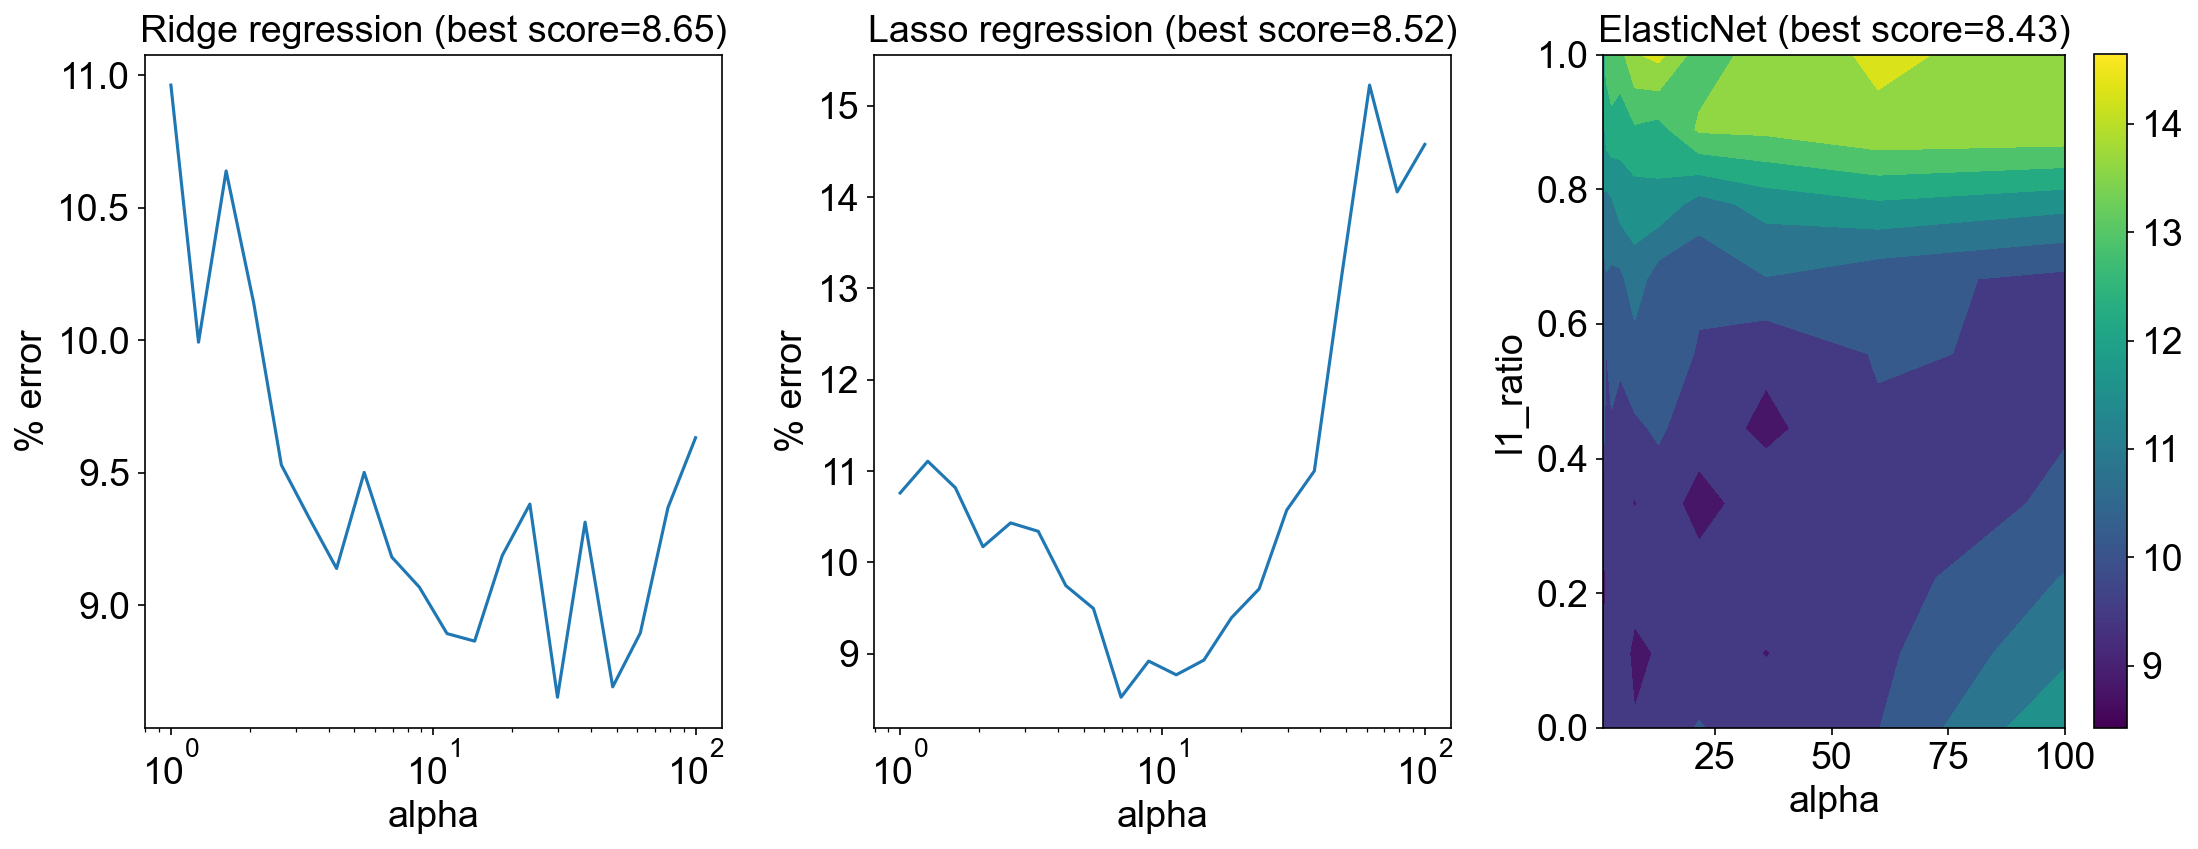

In [129]:
def plot_gridsearch(gridsearch):
    fig, axes = plt.subplots(1,3,figsize=(15,6))

    ax = axes[0]
    ax.semilogx(*gridsearch["Ridge"])
    ax.set_xlabel("alpha")
    ax.set_ylabel("% error")
    ax.set_title(f"Ridge regression (best score={np.min(gridsearch['Ridge'][1]):.2f})")

    ax = axes[1]
    ax.semilogx(*gridsearch["Lasso"])
    ax.set_xlabel("alpha")
    ax.set_ylabel("% error")
    ax.set_title(f"Lasso regression (best score={np.min(gridsearch['Lasso'][1]):.2f})")

    ax = axes[2]
    ax.contourf(*gridsearch["ElasticNet"])
    ax.set_title(f"ElasticNet (best score={np.min(gridsearch['ElasticNet'][2]):.2f})")
    ax.set_xlabel("alpha")
    ax.set_ylabel("l1_ratio")
    vmin = np.min(gridsearch['ElasticNet'][2])
    vmax = np.max(gridsearch['ElasticNet'][2])
    plt.colorbar(cm.ScalarMappable(colors.Normalize(vmin=vmin, vmax=vmax)), ax=ax)

    fig.tight_layout()
    return fig

fig = plot_gridsearch(gridsearch)
fig.savefig(OUTPUT_DIR + "manual_gridsearch.pdf")

### Manual, high corr features

In [139]:
gridsearch_highcorr = manual_gridsearch(high_corr_form_features, yvar70)

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.78265948750959, tolerance: 5.746560000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.438311191190223, tolerance: 5.6307333333333345
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.641771627975686, tolerance: 6.486493333333334
  model

0


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14686.210768633397, tolerance: 7.4808933333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9158.767589507053, tolerance: 5.191333333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15636.214559255099, tolerance: 7.8343733333333345
  mo

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8919.653860607697, tolerance: 4.796693333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13062.575903748111, tolerance: 6.134933333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9752.848670321975, tolerance: 5.216293333333335
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.843195939722136, tolerance: 5.129493333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.624049880168968, tolerance: 5.650293333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.536950094132408, tolerance: 5.698773333333334
  model

1


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15289.441649938703, tolerance: 7.277093333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15942.01703014583, tolerance: 6.807733333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15786.50095136575, tolerance: 8.17016
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15388.316447978355, tolerance: 7.172093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15206.321811029977, tolerance: 7.619893333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13343.933491420534, tolerance: 7.107360000000001
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.427931917505703, tolerance: 5.23076
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.481073362772804, tolerance: 5.07144
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16133.024063800982, tolerance: 7.275200000000001
  model = cd_fast.enet_coor

2


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15987.776668559194, tolerance: 8.418093333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17021.90929284091, tolerance: 6.763773333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18196.88592141305, tolerance: 6.727360000000001
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17504.027659267776, tolerance: 7.532959999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10206.950289860808, tolerance: 4.819493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15225.267030587422, tolerance: 6.828773333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.872969855763586, tolerance: 4.295693333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12015.600344163695, tolerance: 4.842173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17208.870405517184, tolerance: 6.408173333333334
  mode

3


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19541.64450248847, tolerance: 7.229173333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19234.909503046525, tolerance: 6.710533333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19803.214875488928, tolerance: 7.051200000000001
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.706830969514158, tolerance: 5.3624
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.778260377677725, tolerance: 5.514773333333333
  model = cd_fast.enet_coordinate_descent(


4


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14686.384113908276, tolerance: 6.005093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22141.630589241653, tolerance: 7.635973333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19918.244492950933, tolerance: 7.303093333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20335.12926416483, tolerance: 7.896800000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18988.429317220525, tolerance: 6.398733333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23110.666118578018, tolerance: 7.732773333333334
  mode

5


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14846.462696737864, tolerance: 4.831293333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13642.904728213436, tolerance: 4.502973333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24600.917640094427, tolerance: 7.220240000000001
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23264.45011785837, tolerance: 7.456640000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24491.366725342337, tolerance: 7.477560000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24510.8893511297, tolerance: 7.068373333333333
  model 

6


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17581.003403083043, tolerance: 5.021493333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19507.978025101504, tolerance: 5.572133333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27980.463619719005, tolerance: 7.532933333333333
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27251.29398179609, tolerance: 7.303093333333336
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26889.079600054993, tolerance: 7.475533333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26268.34567413169, tolerance: 7.245839999999999
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29814.17872620508, tolerance: 8.032773333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16479.72458169135, tolerance: 4.542093333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21875.122898740774, tolerance: 5.575773333333333
  model

7


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31341.065688807787, tolerance: 7.798933333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29773.433279546913, tolerance: 7.099733333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28510.314039732315, tolerance: 6.946693333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29503.80373825033, tolerance: 7.24364
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32750.669710940478, tolerance: 8.279493333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31639.06548543423, tolerance: 7.958733333333335
  model = cd_fast

8


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31342.1864466542, tolerance: 7.083893333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22976.242132069903, tolerance: 5.33784
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30340.911948271765, tolerance: 7.013693333333333
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28155.09975824536, tolerance: 6.408173333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32905.8762266967, tolerance: 7.691360000000002
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24961.130070399813, tolerance: 5.787373333333332
  model 

9


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33316.01216532303, tolerance: 7.212773333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36995.977276630096, tolerance: 8.063293333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23656.300895901382, tolerance: 5.20016
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35555.12952662351, tolerance: 7.839359999999998
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34435.11946700806, tolerance: 7.557493333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31230.253763411733, tolerance: 6.7826933333333335
  mode

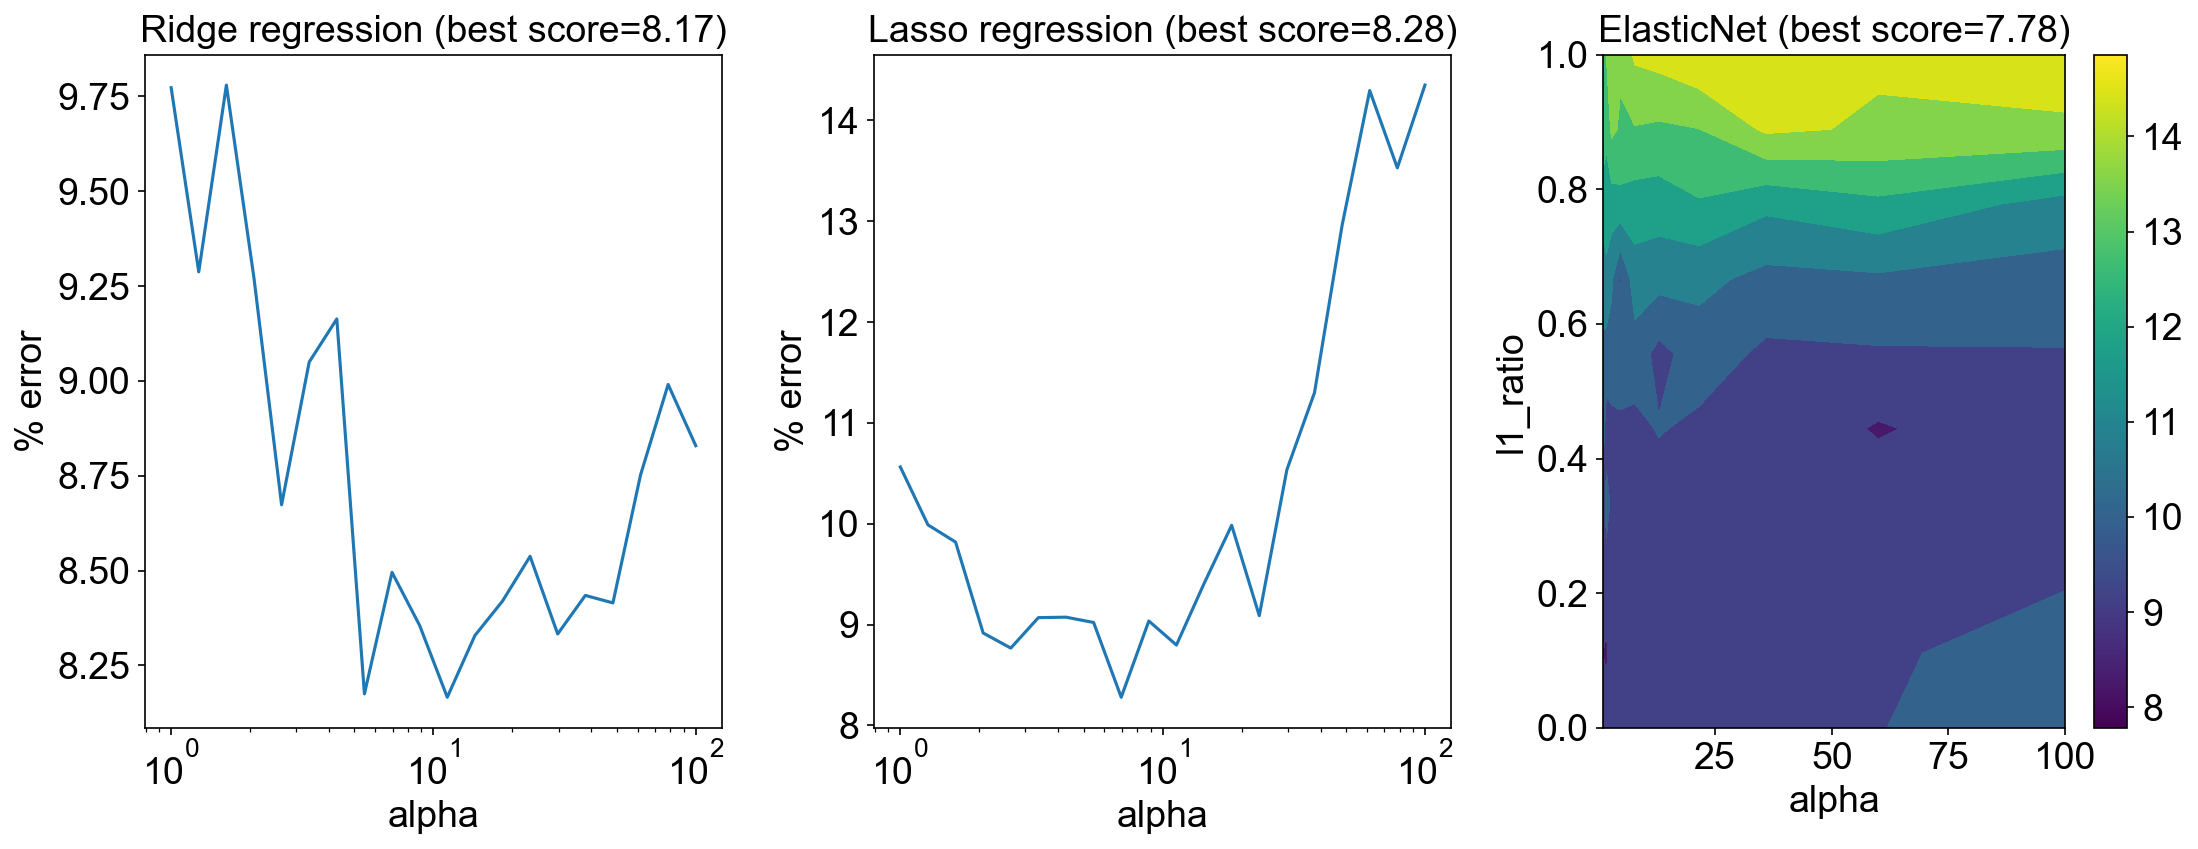

In [140]:
fig = plot_gridsearch(gridsearch_highcorr)
fig.savefig(OUTPUT_DIR + "manual_gridsearch_highcorr.pdf")

0


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25254.23245345318, tolerance: 7.302293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21914.34105132937, tolerance: 6.343133333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22568.82663336861, tolerance: 6.848640000000001
  model 

1


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29448.27970611529, tolerance: 8.422493333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26934.348135720968, tolerance: 7.052760000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18497.779819563002, tolerance: 4.923093333333334
  mode

2


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28604.26558064779, tolerance: 6.8125333333333336
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28923.689438419817, tolerance: 7.098293333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22870.695443989243, tolerance: 5.62136
  model = cd_fa

3


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32289.12464049655, tolerance: 7.4198400000000015
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28690.820366262138, tolerance: 6.436493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21023.27875140696, tolerance: 4.78284
  model = cd_fas

4


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37034.25058262217, tolerance: 8.0976
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34522.399733651655, tolerance: 7.4854933333333324
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38086.260291677645, tolerance: 8.378160000000001
  model = cd_fas

5


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24748.84564500587, tolerance: 5.214239999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35530.979442673604, tolerance: 7.4672
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38904.37030453136, tolerance: 8.202693333333336
  model = cd_fast.

6


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32063.245195046686, tolerance: 6.585773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25108.600698616945, tolerance: 5.185893333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26645.87001872179, tolerance: 5.463360000000001
  mode

7


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25022.010233569403, tolerance: 5.10216
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28443.445573485264, tolerance: 5.776559999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34581.667356419755, tolerance: 7.0410400000000015
  model = cd_f

8


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34435.03700203115, tolerance: 6.970293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36257.49996555687, tolerance: 7.329973333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36742.072210356484, tolerance: 7.439093333333332
  model

9


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26126.73226810572, tolerance: 5.268000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38991.634327670756, tolerance: 7.852493333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33011.051448140985, tolerance: 6.6432
  model = cd_fast

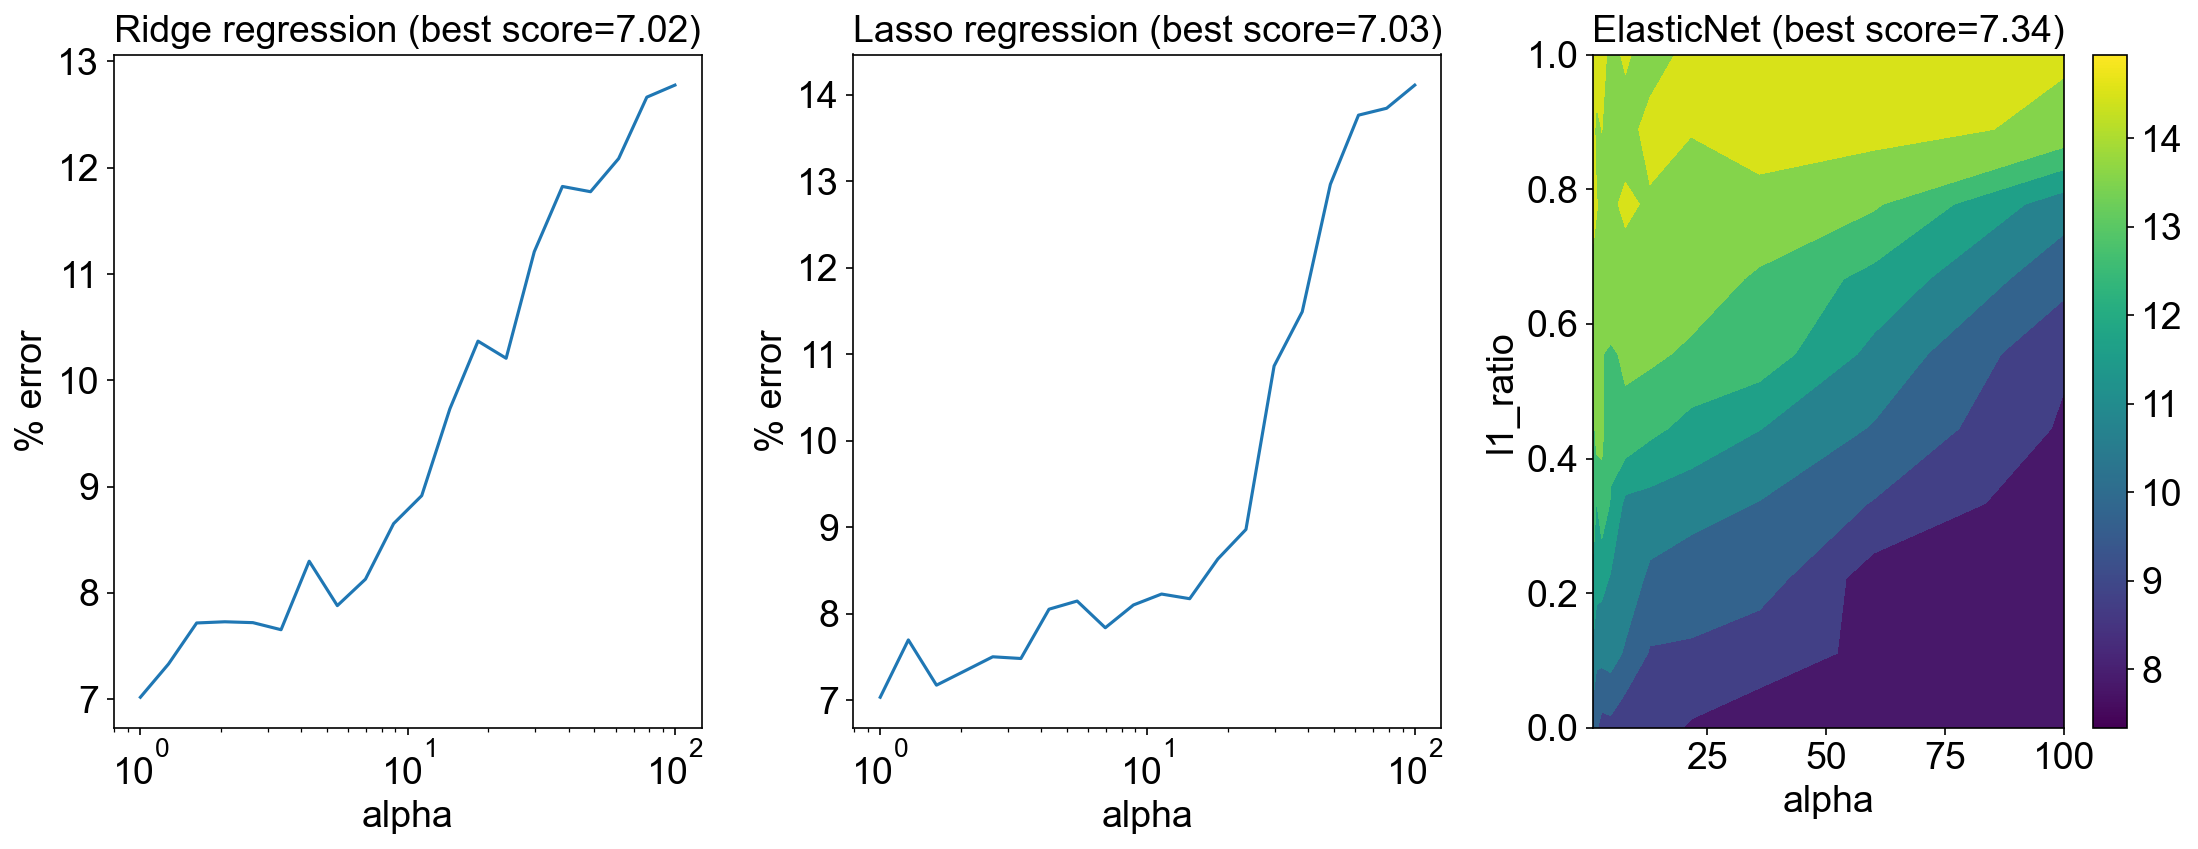

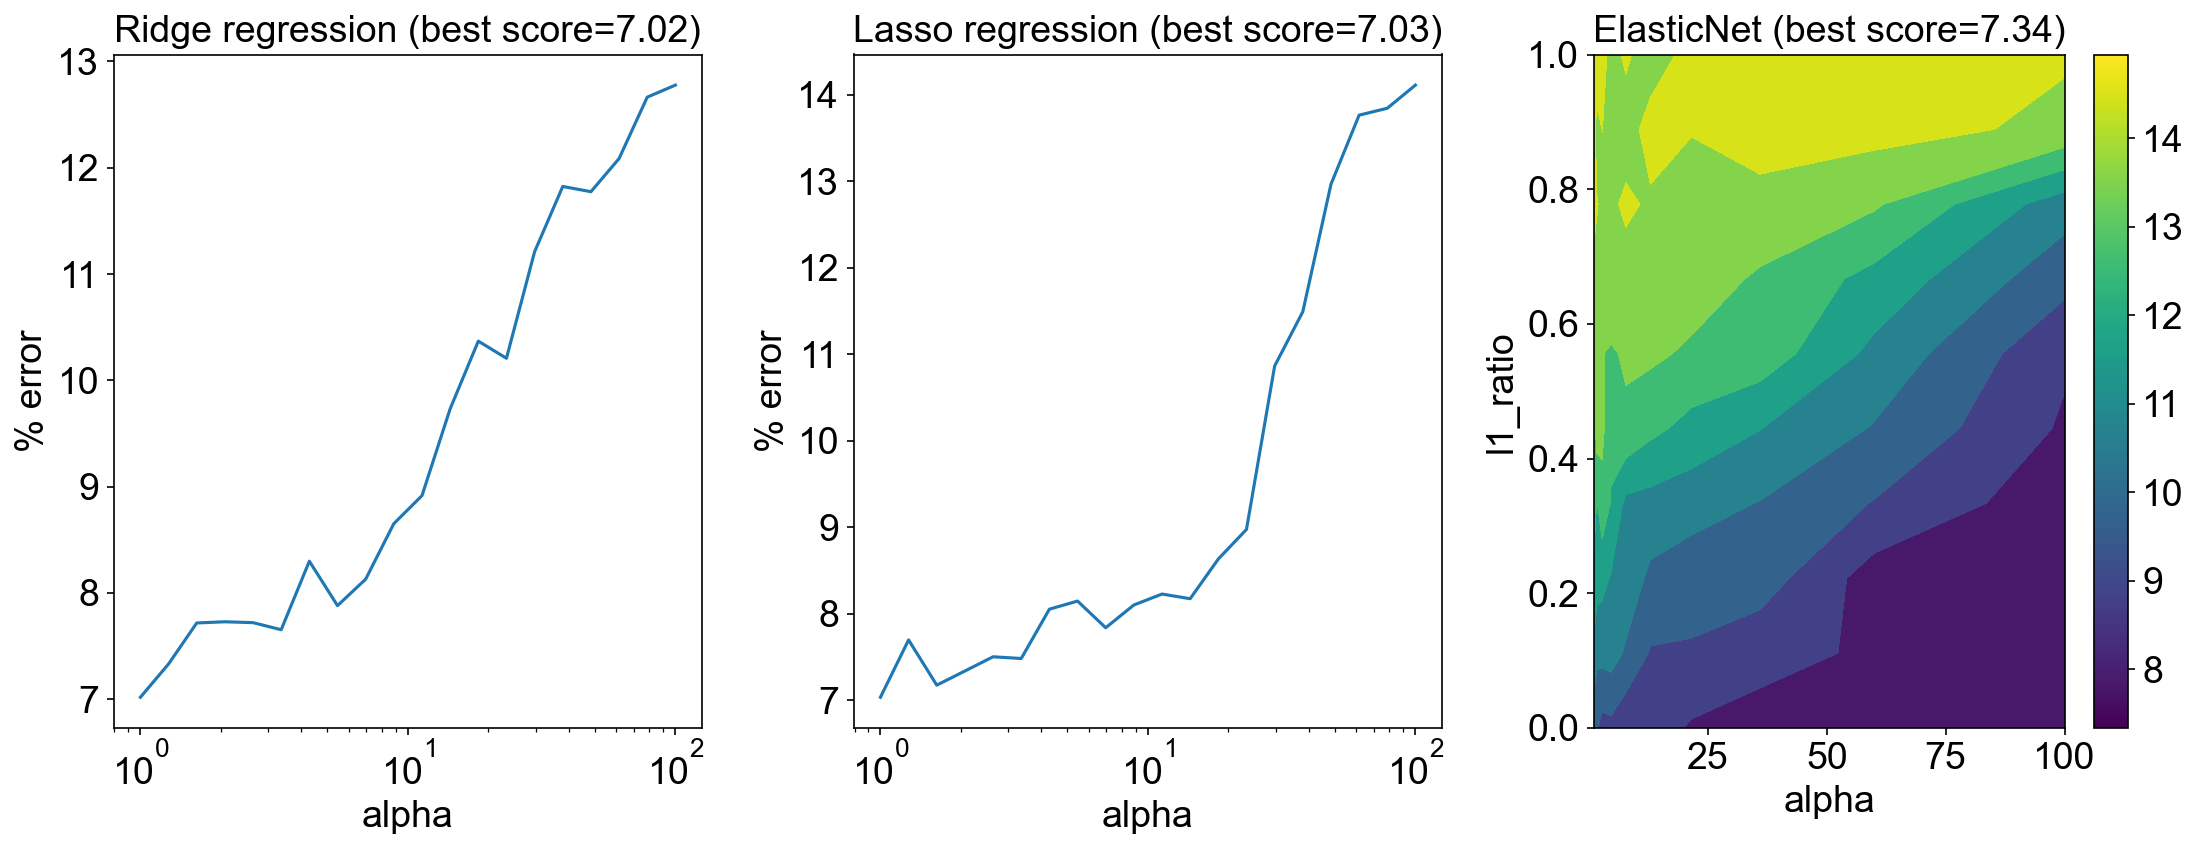

In [186]:
plot_gridsearch(manual_gridsearch("form_first_discharge_capacity_ah", yvar70))

### Manual, very high corr

In [141]:
gridsearch_veryhighcorr = manual_gridsearch(very_high_corr_form_features, yvar70)

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.335844967818048, tolerance: 4.84176
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.03005341572134, tolerance: 5.452293333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.416691422038639, tolerance: 5.328293333333334
  model = cd_fast.e

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.977735486427264, tolerance: 5.411693333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4655335089119035, tolerance: 5.660933333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.808119361114223, tolerance: 5.991359999999999
  model

0


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14179.609946407012, tolerance: 7.997573333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16557.92887215299, tolerance: 7.945933333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7458.6130313966, tolerance: 4.912893333333333
  model =

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15603.1269942573, tolerance: 6.8222933333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15806.978628431398, tolerance: 7.0581733333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14801.745502202542, tolerance: 6.807493333333335
  mod

1


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17525.124053025604, tolerance: 8.097933333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17398.147162893725, tolerance: 7.609933333333331
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14193.026901805935, tolerance: 6.743733333333333
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16000.833504405084, tolerance: 7.622373333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17263.880107501755, tolerance: 7.926133333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16422.997623053445, tolerance: 7.7245333333333335
  mo

2


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19175.391733891727, tolerance: 7.3616
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20085.115368445615, tolerance: 7.662373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17902.03362074888, tolerance: 7.1136
  model = cd_fast.enet_coord

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.118060809749295, tolerance: 5.52864
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.937076855021587, tolerance: 4.40076
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22356.88012208243, tolerance: 7.631573333333333
  model = cd_fast.enet_coord

3


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21785.123832093326, tolerance: 6.944733333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21793.455535473353, tolerance: 6.913759999999998
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22945.456612330956, tolerance: 7.5898400000000015
  mo

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.968984026980252, tolerance: 5.20416
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.829802398568063, tolerance: 4.854773333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25156.39436400491, tolerance: 7.0644
  model = cd_fast.enet_coordi

4


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26694.981354549833, tolerance: 7.786640000000003
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27166.697291244134, tolerance: 7.831573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15242.479661974392, tolerance: 4.298493333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.464077236796584, tolerance: 5.299773333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.99754628258961, tolerance: 5.953493333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29566.597499449563, tolerance: 7.447333333333333
  model 

5


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22226.887029591817, tolerance: 5.718773333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20154.8260110857, tolerance: 5.2401333333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25884.74388244296, tolerance: 6.436493333333334
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.558658494341216, tolerance: 5.480293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31521.86585925277, tolerance: 7.305093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26396.67273175528, tolerance: 6.1143600000000005
  model

6


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23332.942032300623, tolerance: 5.510693333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32774.930755630194, tolerance: 7.711093333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33225.447252193706, tolerance: 7.835933333333333
  mod

7


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29033.75348666792, tolerance: 6.36064
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28237.721220449188, tolerance: 6.215773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22423.276591915303, tolerance: 4.993173333333333
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32475.559445845844, tolerance: 7.124533333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34066.766016393274, tolerance: 7.5094933333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23153.588390752662, tolerance: 5.149039999999999
  mo

8


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30496.245531293713, tolerance: 6.491293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32281.335935136744, tolerance: 6.840959999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34319.72098912251, tolerance: 7.29024
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33076.869744606556, tolerance: 7.039973333333336
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35284.78068452121, tolerance: 7.5347733333333355
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32748.604939036075, tolerance: 6.979573333333335
  mod

9


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33664.71964507052, tolerance: 6.977773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34149.76829715948, tolerance: 7.11024
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21312.951112548595, tolerance: 4.458093333333333
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24833.904857633708, tolerance: 5.152640000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25247.874078675744, tolerance: 5.286560000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40347.74120709604, tolerance: 8.439493333333333
  mode

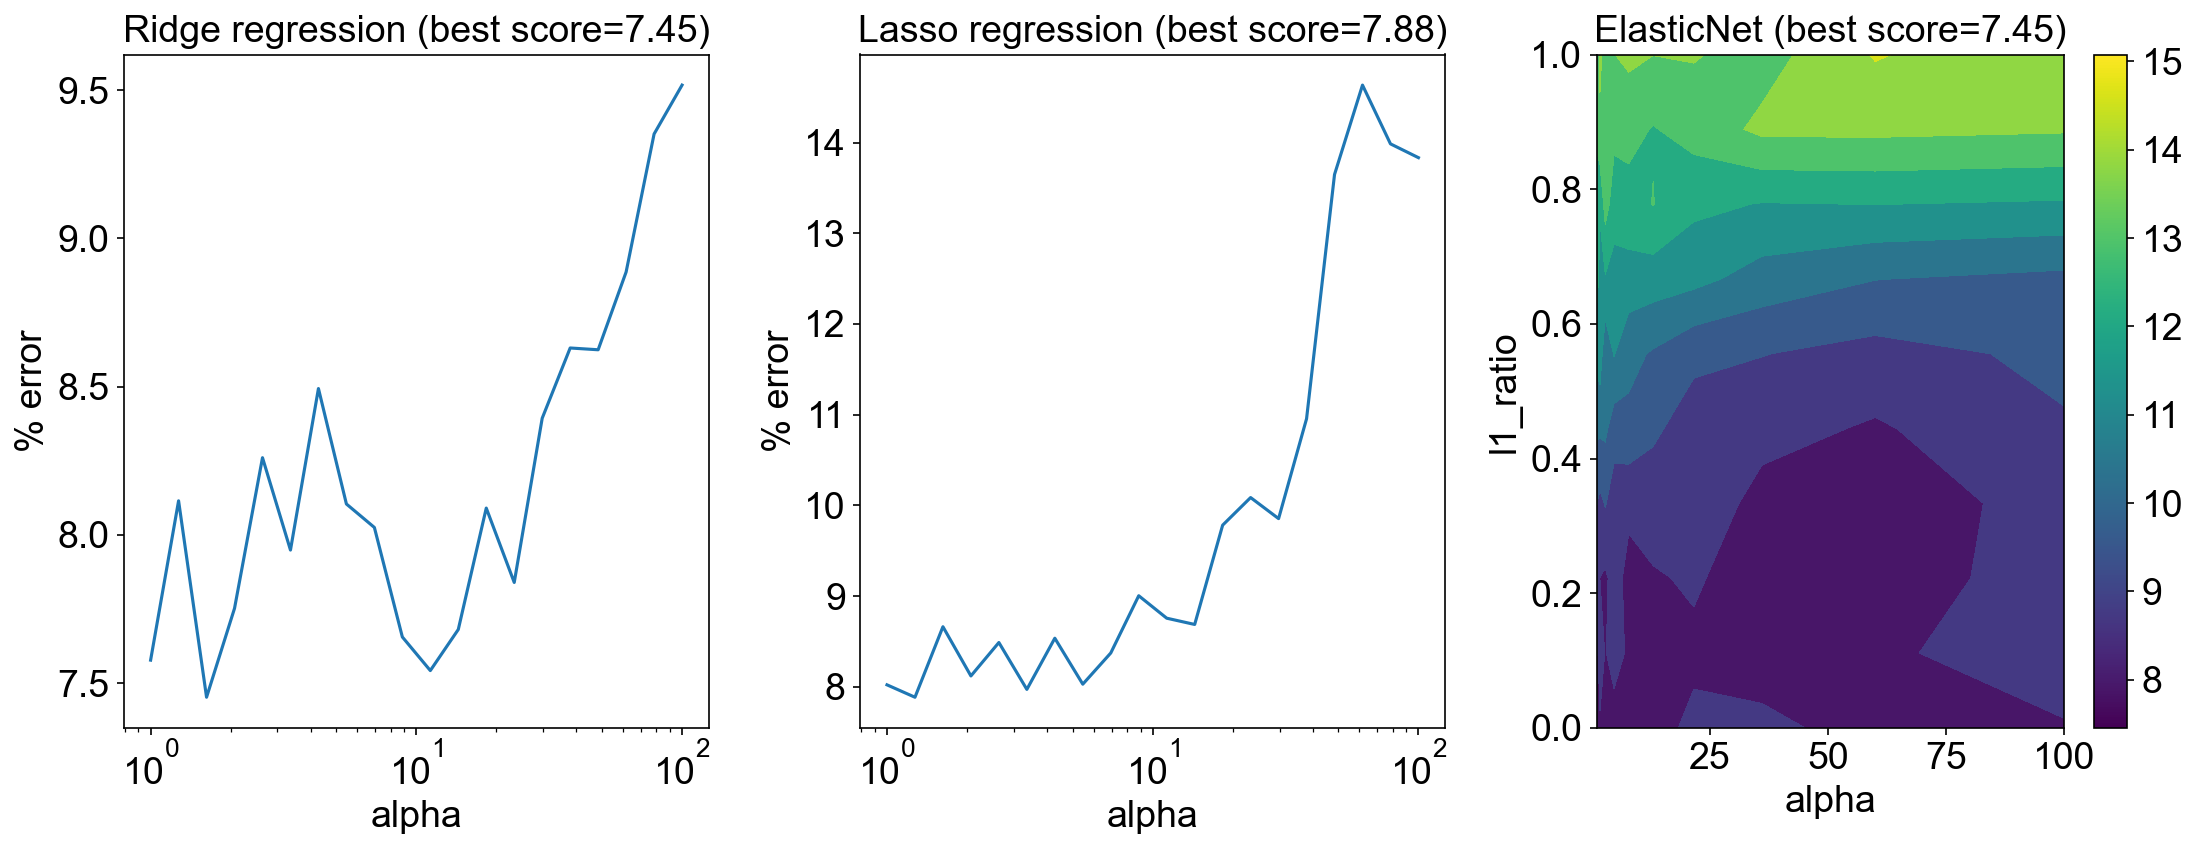

In [142]:
fig = plot_gridsearch(gridsearch_veryhighcorr)
fig.savefig(OUTPUT_DIR + "manual_gridsearch_veryhighcorr.pdf")

In [189]:
yvar

'cycles_to_50_pct'

## Printing lots of models

In [309]:
def print_model(model, yvar, **kwargs):
    print(model)
    print("Label: ", yvar)
    for f in very_high_corr_form_features:
        out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000,
                                  **kwargs)
        print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
    out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000,
                              **kwargs)
    print(f"{'Dummy regressor (predict mean)':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, very_high_corr_form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'very high corr':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, high_corr_form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'high corr':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'all':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    # out = train_and_test_model(df, very_high_corr_form_features, yvar, to_plot=0, model=Lasso(5), num_experiments=1000)
    # print(f"{'Lasso(5), very high corr':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    

In [203]:
print_model(ElasticNet(alpha=50, l1_ratio=0.3), yvar70)

ElasticNet(alpha=50, l1_ratio=0.3)
Label:  cycles_to_70_pct
form_first_discharge_capacity_below_3p2v_ah       7.69 (2.56 std)
form_last_charge_voltage_after_1s                 7.35 (2.52 std)
form_last_charge_voltage_after_60s                7.68 (2.73 std)
form_first_discharge_capacity_ah                  7.49 (2.52 std)
form_first_cycle_efficiency                       7.30 (2.48 std)
form_c20_charge_right_peak_v_per_ah               8.34 (2.67 std)
Dummy regressor (predict mean)          14.17 (4.03 std)
very high corr                          13.20 (3.70 std)
high corr                               12.14 (3.67 std)
all                                     12.23 (3.73 std)


In [204]:
print_model(Ridge(10), yvar50)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.25 (2.49 std)
form_last_charge_voltage_after_1s                 7.13 (2.45 std)
form_last_charge_voltage_after_60s                7.23 (2.31 std)
form_first_discharge_capacity_ah                  7.19 (2.40 std)
form_first_cycle_efficiency                       7.19 (2.43 std)
form_c20_charge_right_peak_v_per_ah               8.10 (2.18 std)
Dummy regressor (predict mean)          12.81 (2.98 std)
very high corr                          7.23 (2.33 std)
high corr                               7.66 (2.34 std)
all                                     8.99 (2.71 std)


In [207]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, log=False)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.20 (2.55 std)
form_last_charge_voltage_after_1s                 7.18 (2.34 std)
form_last_charge_voltage_after_60s                7.27 (2.33 std)
form_first_discharge_capacity_ah                  7.08 (2.40 std)
form_first_cycle_efficiency                       7.07 (2.38 std)
form_c20_charge_right_peak_v_per_ah               8.04 (2.24 std)
Dummy regressor (predict mean)          12.72 (3.16 std)
very high corr                          7.39 (2.35 std)
high corr                               7.86 (2.46 std)
all                                     9.02 (2.66 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.43 (2.57 std)
form_last_charge_voltage_after_1s                 7.41 (2.67 std)
form_last_charge_voltage_after_60s                7.33 (2.52 std)
form_first_discharge_capacity_ah                  7.31 (2.53 std)
form_first_cycle_efficiency      

In [206]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, log=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.00 (2.33 std)
form_last_charge_voltage_after_1s                 7.10 (2.40 std)
form_last_charge_voltage_after_60s                6.87 (2.24 std)
form_first_discharge_capacity_ah                  7.05 (2.34 std)
form_first_cycle_efficiency                       7.02 (2.38 std)
form_c20_charge_right_peak_v_per_ah               7.97 (2.27 std)
Dummy regressor (predict mean)          12.78 (2.93 std)
very high corr                          7.25 (2.26 std)
high corr                               7.57 (2.47 std)
all                                     8.47 (2.54 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.29 (2.49 std)
form_last_charge_voltage_after_1s                 7.32 (2.56 std)
form_last_charge_voltage_after_60s                7.34 (2.45 std)
form_first_discharge_capacity_ah                  7.21 (2.49 std)
form_first_cycle_efficiency      

In [310]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, square=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.55 (2.54 std)
form_last_charge_voltage_after_1s                 7.26 (2.19 std)
form_last_charge_voltage_after_60s                7.33 (2.33 std)
form_first_discharge_capacity_ah                  7.25 (2.40 std)
form_first_cycle_efficiency                       7.22 (2.26 std)
form_c20_charge_right_peak_v_per_ah               8.14 (2.26 std)
Dummy regressor (predict mean)          12.88 (3.35 std)
very high corr                          7.54 (2.39 std)
high corr                               7.73 (2.40 std)
all                                     9.47 (2.88 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.52 (2.69 std)
form_last_charge_voltage_after_1s                 7.53 (2.52 std)
form_last_charge_voltage_after_60s                7.76 (2.58 std)
form_first_discharge_capacity_ah                  7.51 (2.53 std)
form_first_cycle_efficiency      

In [311]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, sqrt=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.11 (2.44 std)
form_last_charge_voltage_after_1s                 7.16 (2.45 std)
form_last_charge_voltage_after_60s                7.07 (2.28 std)
form_first_discharge_capacity_ah                  7.03 (2.38 std)
form_first_cycle_efficiency                       7.08 (2.41 std)
form_c20_charge_right_peak_v_per_ah               7.96 (2.24 std)
Dummy regressor (predict mean)          12.87 (3.06 std)
very high corr                          7.38 (2.21 std)
high corr                               7.62 (2.38 std)
all                                     8.72 (2.52 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.48 (2.52 std)
form_last_charge_voltage_after_1s                 7.48 (2.46 std)
form_last_charge_voltage_after_60s                7.52 (2.53 std)
form_first_discharge_capacity_ah                  7.33 (2.48 std)
form_first_cycle_efficiency      

## PCA

In [155]:
df_form.corr()["form_first_discharge_capacity_ah"].sort_values()

form_last_charge_voltage_after_60s            -0.980230
form_6hr_rest_delta_voltage_v_0_to_3_hr       -0.916008
form_6hr_rest_delta_voltage_v_0_to_2_hr       -0.914781
form_6hr_rest_delta_voltage_v_0_to_4_hr       -0.914624
form_6hr_rest_delta_voltage_v_0_to_5_hr       -0.905455
form_6hr_rest_delta_voltage_v_0_to_1_hr       -0.904876
form_c20_charge_right_peak_v_per_ah           -0.903794
form_6hr_rest_delta_voltage_v_0_to_6_hr       -0.898297
form_6hr_rest_delta_voltage_v                 -0.894643
form_6hr_rest_mv_per_sec_initial              -0.872921
cycles_to_70_pct                              -0.837300
form_6hr_rest_delta_voltage_v_1_to_6_hr       -0.818817
cycles_to_80_pct                              -0.803796
cycles_to_60_pct                              -0.798211
cycles_to_50_pct                              -0.796603
form_6hr_rest_delta_voltage_v_2_to_6_hr       -0.739569
form_6hr_rest_delta_voltage_v_3_to_6_hr       -0.689817
form_6hr_rest_delta_voltage_v_4_to_6_hr       -0

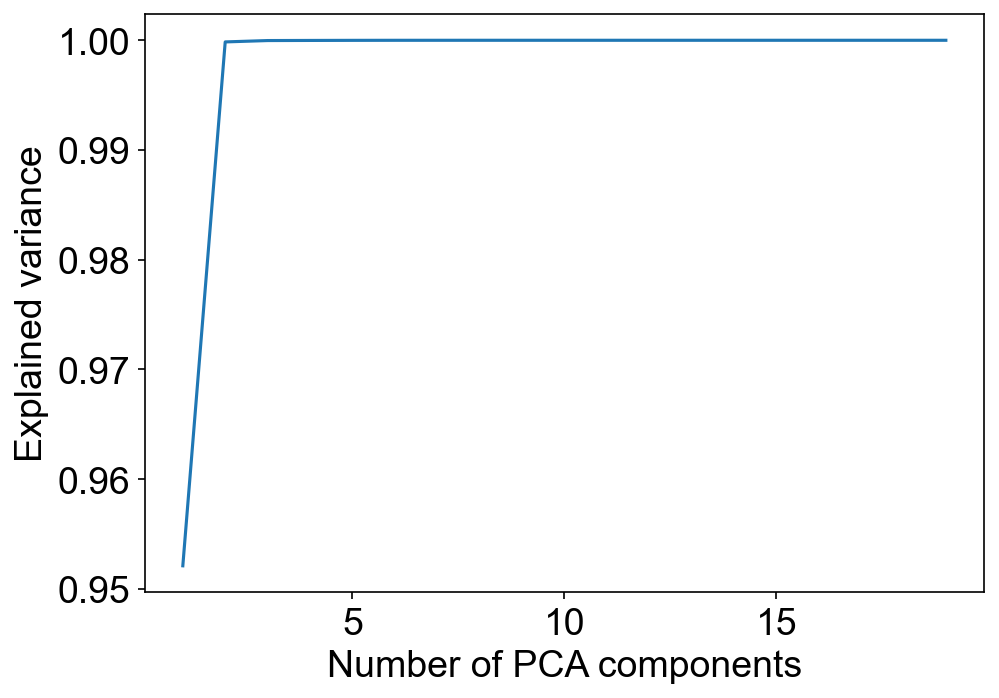

In [234]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_form[form_features])
cumsum = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots()
ax.plot(range(1,len(cumsum)+1),cumsum)
ax.set_xlabel("Number of PCA components")
ax.set_ylabel("Explained variance")
fig.savefig(OUTPUT_DIR + "pca.pdf")

In [268]:
log = False
to_plot = False
yvar = yvar70
model = LinearRegression()
xvars = very_high_corr_form_features
# xvars = ["form_first_discharge_capacity_ah"]

# Fraction of samples reserved for model testing
# e.g. 0.2 means 20% of samples reserved. In the 
# context of cross-validation, this would be 
# equivalent to a 5-fold cross-validation. The 
# cross-validation we end up doing is not exactly
# 5-fold cross-validation since we introduce random
# sampling and many many repeats
TEST_SIZE = 0.2

# Number of trials
num_experiments = 1000

# Unpack and filter data
# Create a temporary df to filter NaNs only from the columns we use
xyvars = xvars + [yvar]
df_nonans = df[xyvars].dropna()
if log is True:
    df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

X = df_nonans[xvars].values
pca = PCA(n_components=0.95)
# print(X)
X = pca.fit_transform(X)
# print(X)
# print(pca.explained_variance_ratio_)
y = df_nonans[yvar].values

percent_error_list = []
r2_score_list = []
rmse_list = []
baseline_rmse_list = []
intercept_list = []
coef_list = []
corr_list = []

has_plotted = 0

for idx in range(num_experiments):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE)

    # apply standard scaler (fit only on train, transform both train and test)
    # keep originals for pltos
    X_train_original = X_train
    X_test_original = X_test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    (model, corr) = build_model(X_train, y_train, model)

    y_pred = model.predict(X_test)
    y_train_mean = np.mean(y_train)

    r2_score = model.score(X_test, y_test)

    if log is True:
        y_train = np.exp(y_train)
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        y_train_mean = np.exp(y_train_mean)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
    percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
    baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

    rmse_list.append(rmse)
    percent_error_list.append(percent_error)
    r2_score_list.append(r2_score)
    baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
    corr_list.append(corr)

    # Give a visual into the cross-validation process
    if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
        has_plotted = 1

        x_fit = np.linspace(np.min(X), np.max(X), 100)
        x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
        y_fit = model.predict(x_fit_trans)
        if log is True:
            y_fit = np.exp(y_fit)
        plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
        plt.plot(X_train_original, y_train, 'o', color='k')
        plt.plot(X_test_original, y_test, 's', color='r')

        for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
            plt.plot([this_x, this_x], 
                     [this_y, this_ypred], 
                     label='', color=(0.3, 0.3, 0.3))

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Model', 'Train', 'Test'])
        plt.show()

# Package the output
final_model = model
# Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)

final_rmse = np.mean(rmse_list)
final_rmse_std = np.std(rmse_list)

final_baseline_rmse = np.mean(baseline_rmse_list)
final_baseline_rmse_std = np.std(baseline_rmse_list)

# Column mean and column std of a list of tuples
final_corr = tuple(map(np.mean, zip(*corr_list)))
final_corr_std = tuple(map(np.std, zip(*corr_list)))

final_percent_error = np.mean(percent_error_list)
final_percent_error_std = np.std(percent_error_list)

#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
final_r2_score = np.mean(r2_score_list)
final_r2_score_std = np.std(r2_score_list)

model_output_dict = dict()
model_output_dict['model'] = final_model
model_output_dict['rmse'] = final_rmse
model_output_dict['rmse_std'] = final_rmse_std
model_output_dict['baseline_rmse'] = final_baseline_rmse
model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
model_output_dict['corr'] = final_corr
model_output_dict['corr_std'] = final_corr_std
model_output_dict['percent_error'] = final_percent_error
model_output_dict['percent_error_std'] = final_percent_error_std
model_output_dict['r2_score'] = final_r2_score
model_output_dict['r2_score_std'] = final_r2_score_std
model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
model_output_dict['features'] = tuple(xvars)

model_output_dict["percent_error"]

7.322525882735457

## Understanding the model

See https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html 

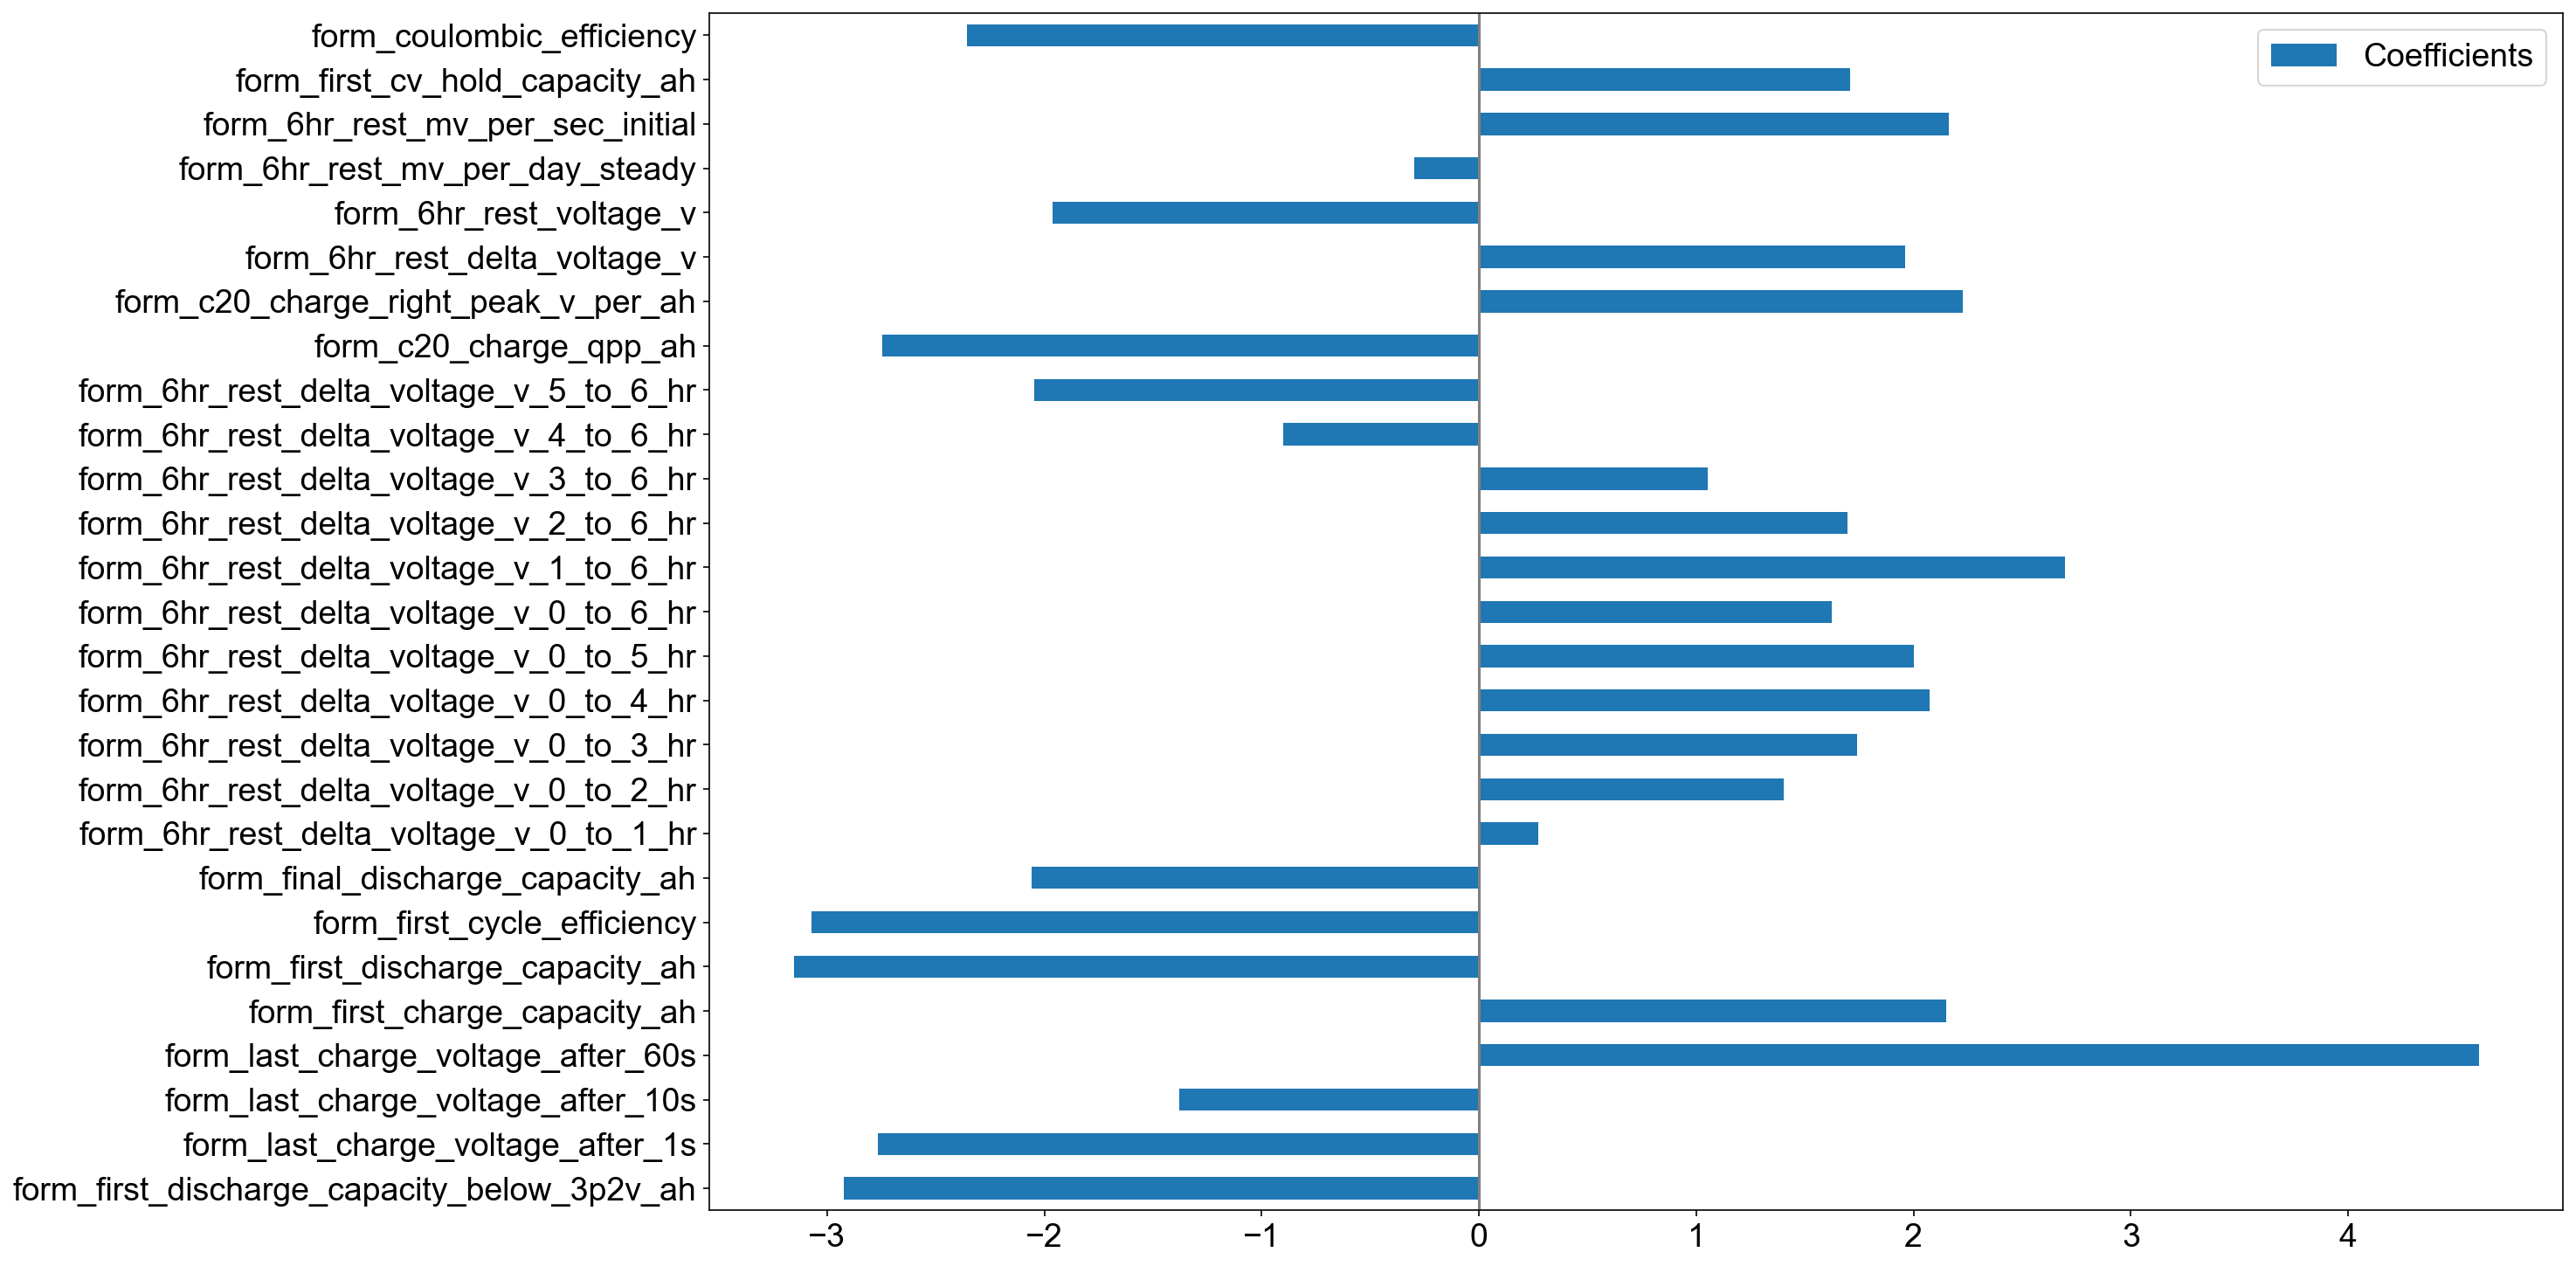

In [115]:
ridge = gridsearch["Ridge"]
alpha_ridge = ridge[0][np.argmin(ridge[1])]
model = Ridge(alpha_ridge)
out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
coefs = pd.DataFrame(
    model.coef_,
    columns=['Coefficients'], index=out["features"]
)
coefs.plot(kind="barh",figsize=(20,10))
plt.axvline(x=0, color='.5')

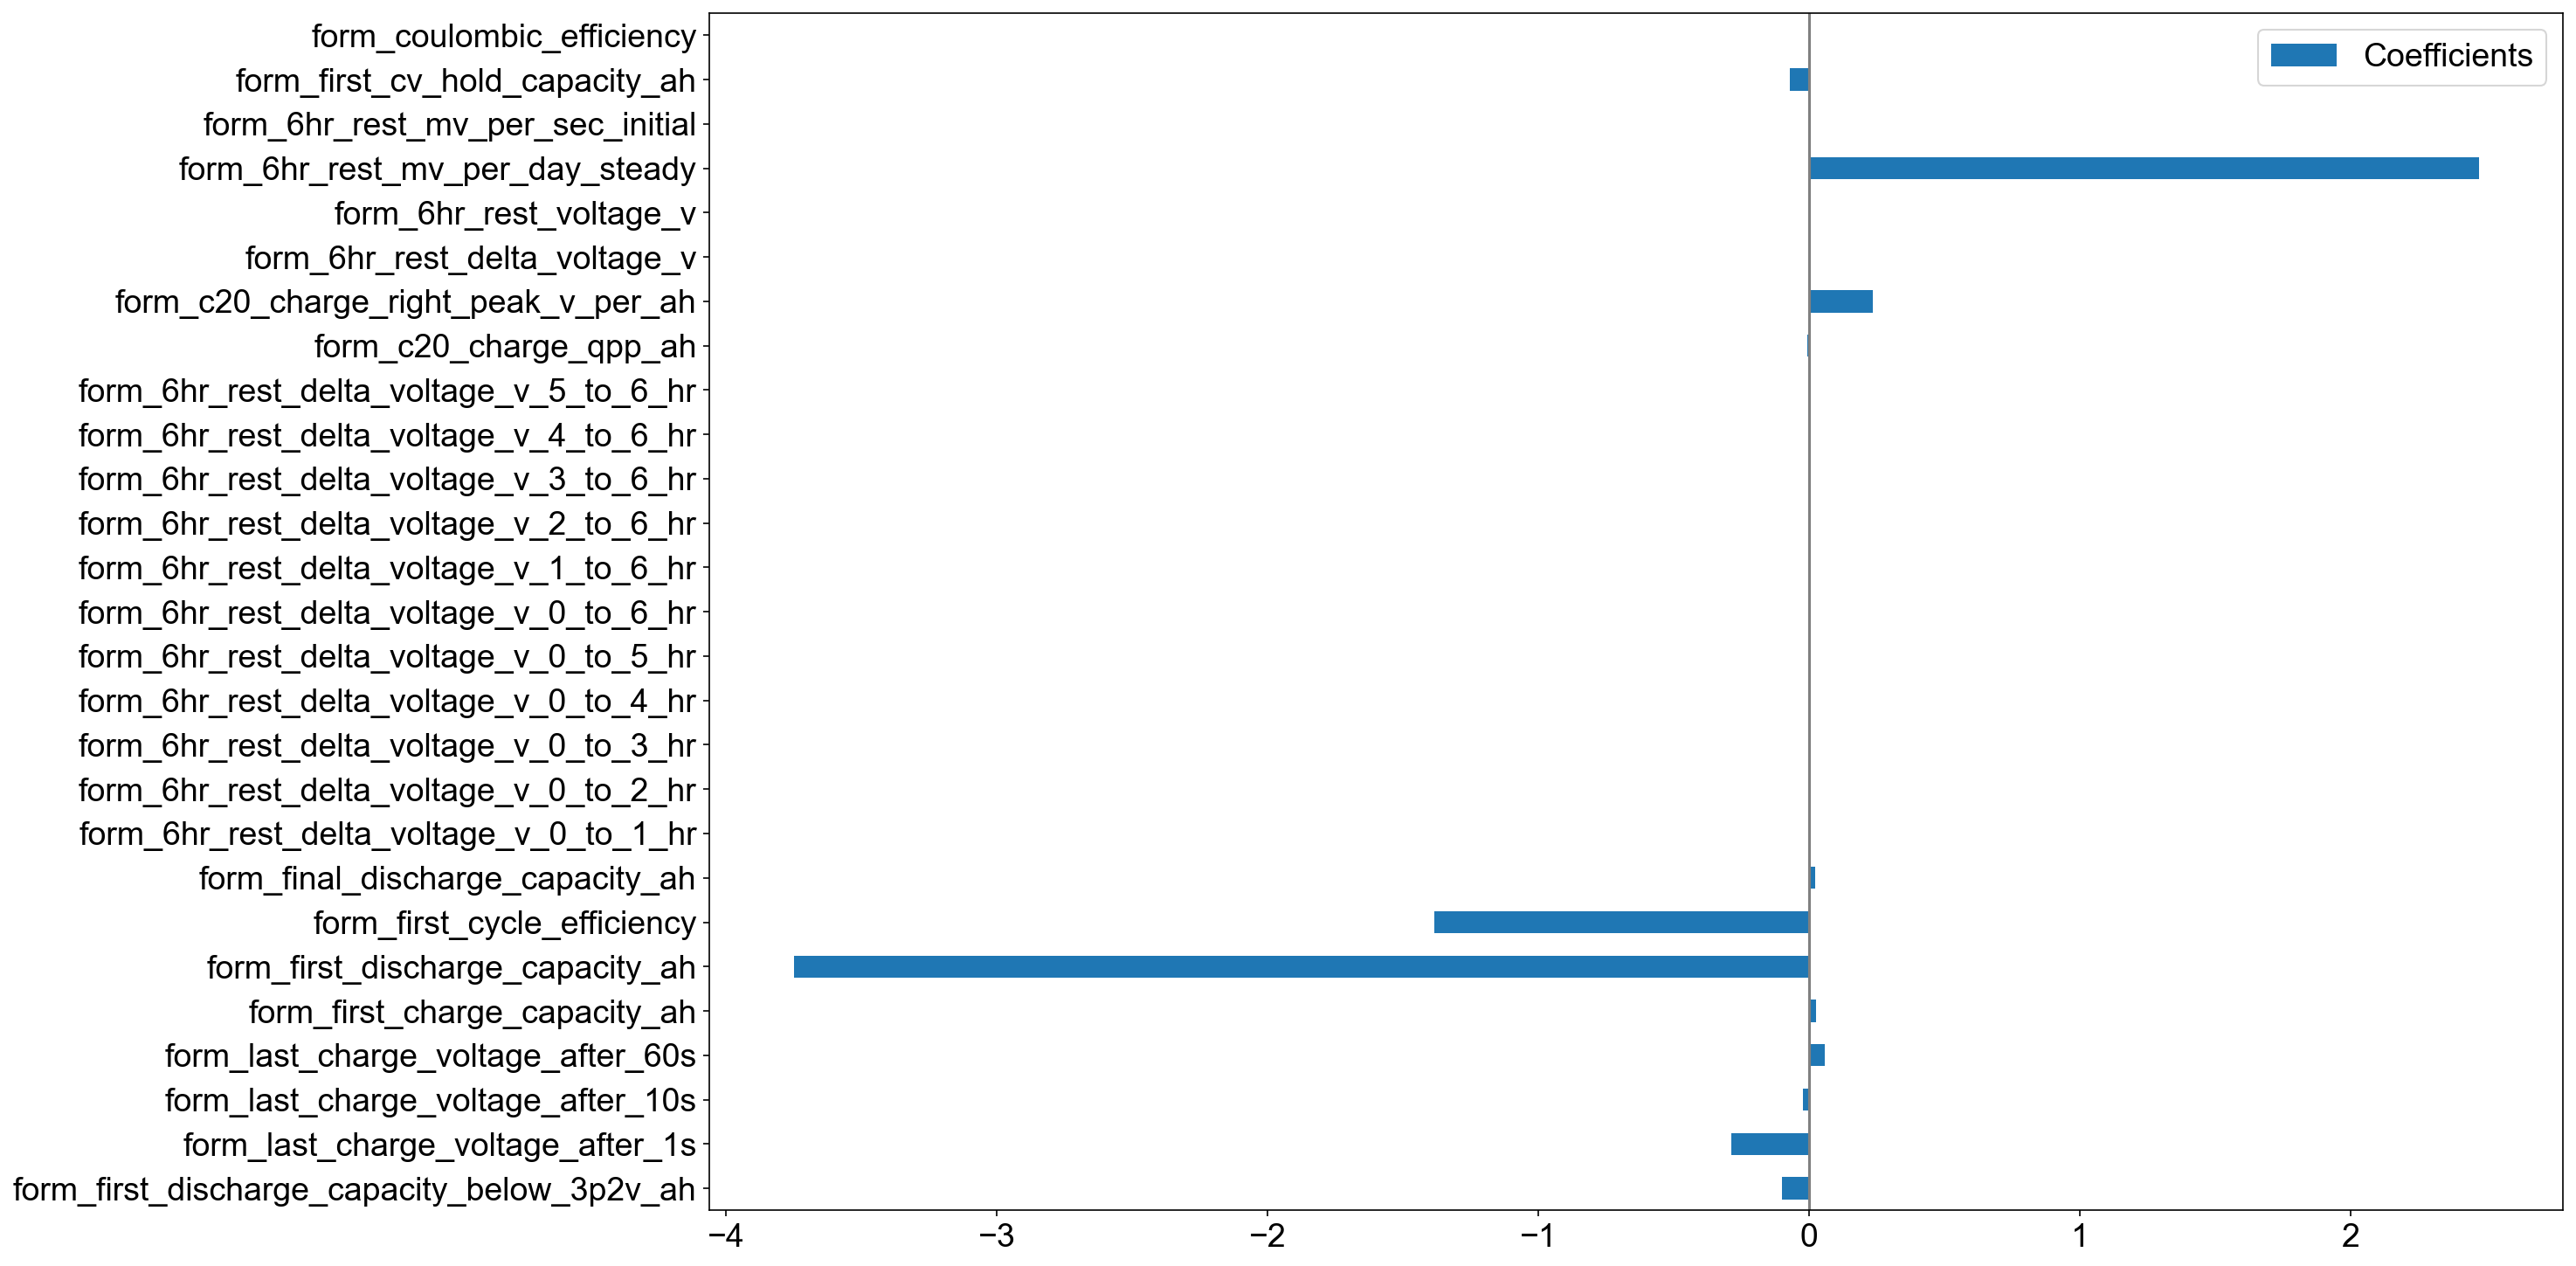

In [213]:
ridge = gridsearch["Ridge"]
alpha_ridge = ridge[0][np.argmin(ridge[1])]
model = Ridge(10)
out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
coefs = pd.DataFrame(
    model.coef_ * df[form_features].std(axis=0),
    columns=['Coefficients'], index=out["features"]
)
coefs.plot(kind="barh",figsize=(20,10))
plt.axvline(x=0, color='.5')
plt.savefig(OUTPUT_DIR + "model_coeffs.png")


In [216]:
feat = ["form_first_discharge_capacity_ah", "form_first_cycle_efficiency"]#, "form_6hr_rest_mv_per_day_steady"]
out = train_and_test_model(df, feat, yvar70, to_plot=0, model=Ridge(10), num_experiments=1000, log=True)
print(f"{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

7.96 (2.54 std)


In [299]:
out = train_and_test_model(df, ["form_first_discharge_capacity_ah", "form_first_cycle_efficiency", "form_6hr_rest_mv_per_day_steady"],
                                yvar70, to_plot=0, model=ElasticNet(alpha=0.01,l1_ratio=0.3), num_experiments=1000,
                                  log=True)
print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

form_coulombic_efficiency                         7.63 (2.68 std)


## Polynomial features

In [315]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=True)

# Up to cycle 3

In [332]:
c3_select = lambda x: x.endswith("_c3") or x.startswith("esoh_c3_")  or x.startswith("rpt_c3_")
c3_features = list(filter(c3_select, df.columns))
label_select = lambda x: x.startswith("cycles_to_")
labels = list(filter(label_select, df.columns))
df_c3 = df[c3_features + labels]
df_c3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   retention_at_c3        19 non-null     float64
 1   dcr_10s_0_soc_at_c3    19 non-null     float64
 2   dcr_3s_0_soc_at_c3     19 non-null     float64
 3   dcr_1s_0_soc_at_c3     19 non-null     float64
 4   dcr_10s_5_soc_at_c3    19 non-null     float64
 5   dcr_3s_5_soc_at_c3     19 non-null     float64
 6   dcr_1s_5_soc_at_c3     19 non-null     float64
 7   dcr_10s_7_soc_at_c3    19 non-null     float64
 8   dcr_3s_7_soc_at_c3     19 non-null     float64
 9   dcr_1s_7_soc_at_c3     19 non-null     float64
 10  dcr_10s_10_soc_at_c3   19 non-null     float64
 11  dcr_3s_10_soc_at_c3    19 non-null     float64
 12  dcr_1s_10_soc_at_c3    19 non-null     float64
 13  dcr_10s_15_soc_at_c3   19 non-null     float64
 14  dcr_3s_15_soc_at_c3    19 non-null     float64
 15  dcr_1s_1

In [330]:
for i in range(10):
    print(df.columns[i*100:(i+1)*100])

Index(['Unnamed: 0', 'cellid', 'channel_number', 'is_room_temp_aging',
       'is_baseline_formation', 'form_first_discharge_capacity_below_3p2v_ah',
       'form_first_discharge_rest_voltage_rebound_1s',
       'form_first_discharge_rest_voltage_rebound_10s',
       'form_first_discharge_rest_voltage_rebound_1800s',
       'form_last_charge_voltage_trace_cap_ah',
       'form_last_charge_voltage_trace_voltage_v',
       'form_last_charge_voltage_after_1s',
       'form_last_charge_voltage_after_10s',
       'form_last_charge_voltage_after_60s', 'form_first_charge_capacity_ah',
       'form_first_discharge_capacity_ah', 'form_first_cycle_efficiency',
       'form_final_discharge_capacity_ah',
       'form_6hr_rest_delta_voltage_v_0_to_1_hr',
       'form_6hr_rest_delta_voltage_v_0_to_2_hr',
       'form_6hr_rest_delta_voltage_v_0_to_3_hr',
       'form_6hr_rest_delta_voltage_v_0_to_4_hr',
       'form_6hr_rest_delta_voltage_v_0_to_5_hr',
       'form_6hr_rest_delta_voltage_v_0_to_6_hr'

# Next steps
- Nested cross-val
- Quadratic error
- Cycle 3